Loaded 420000 rows spanning 3 trading days


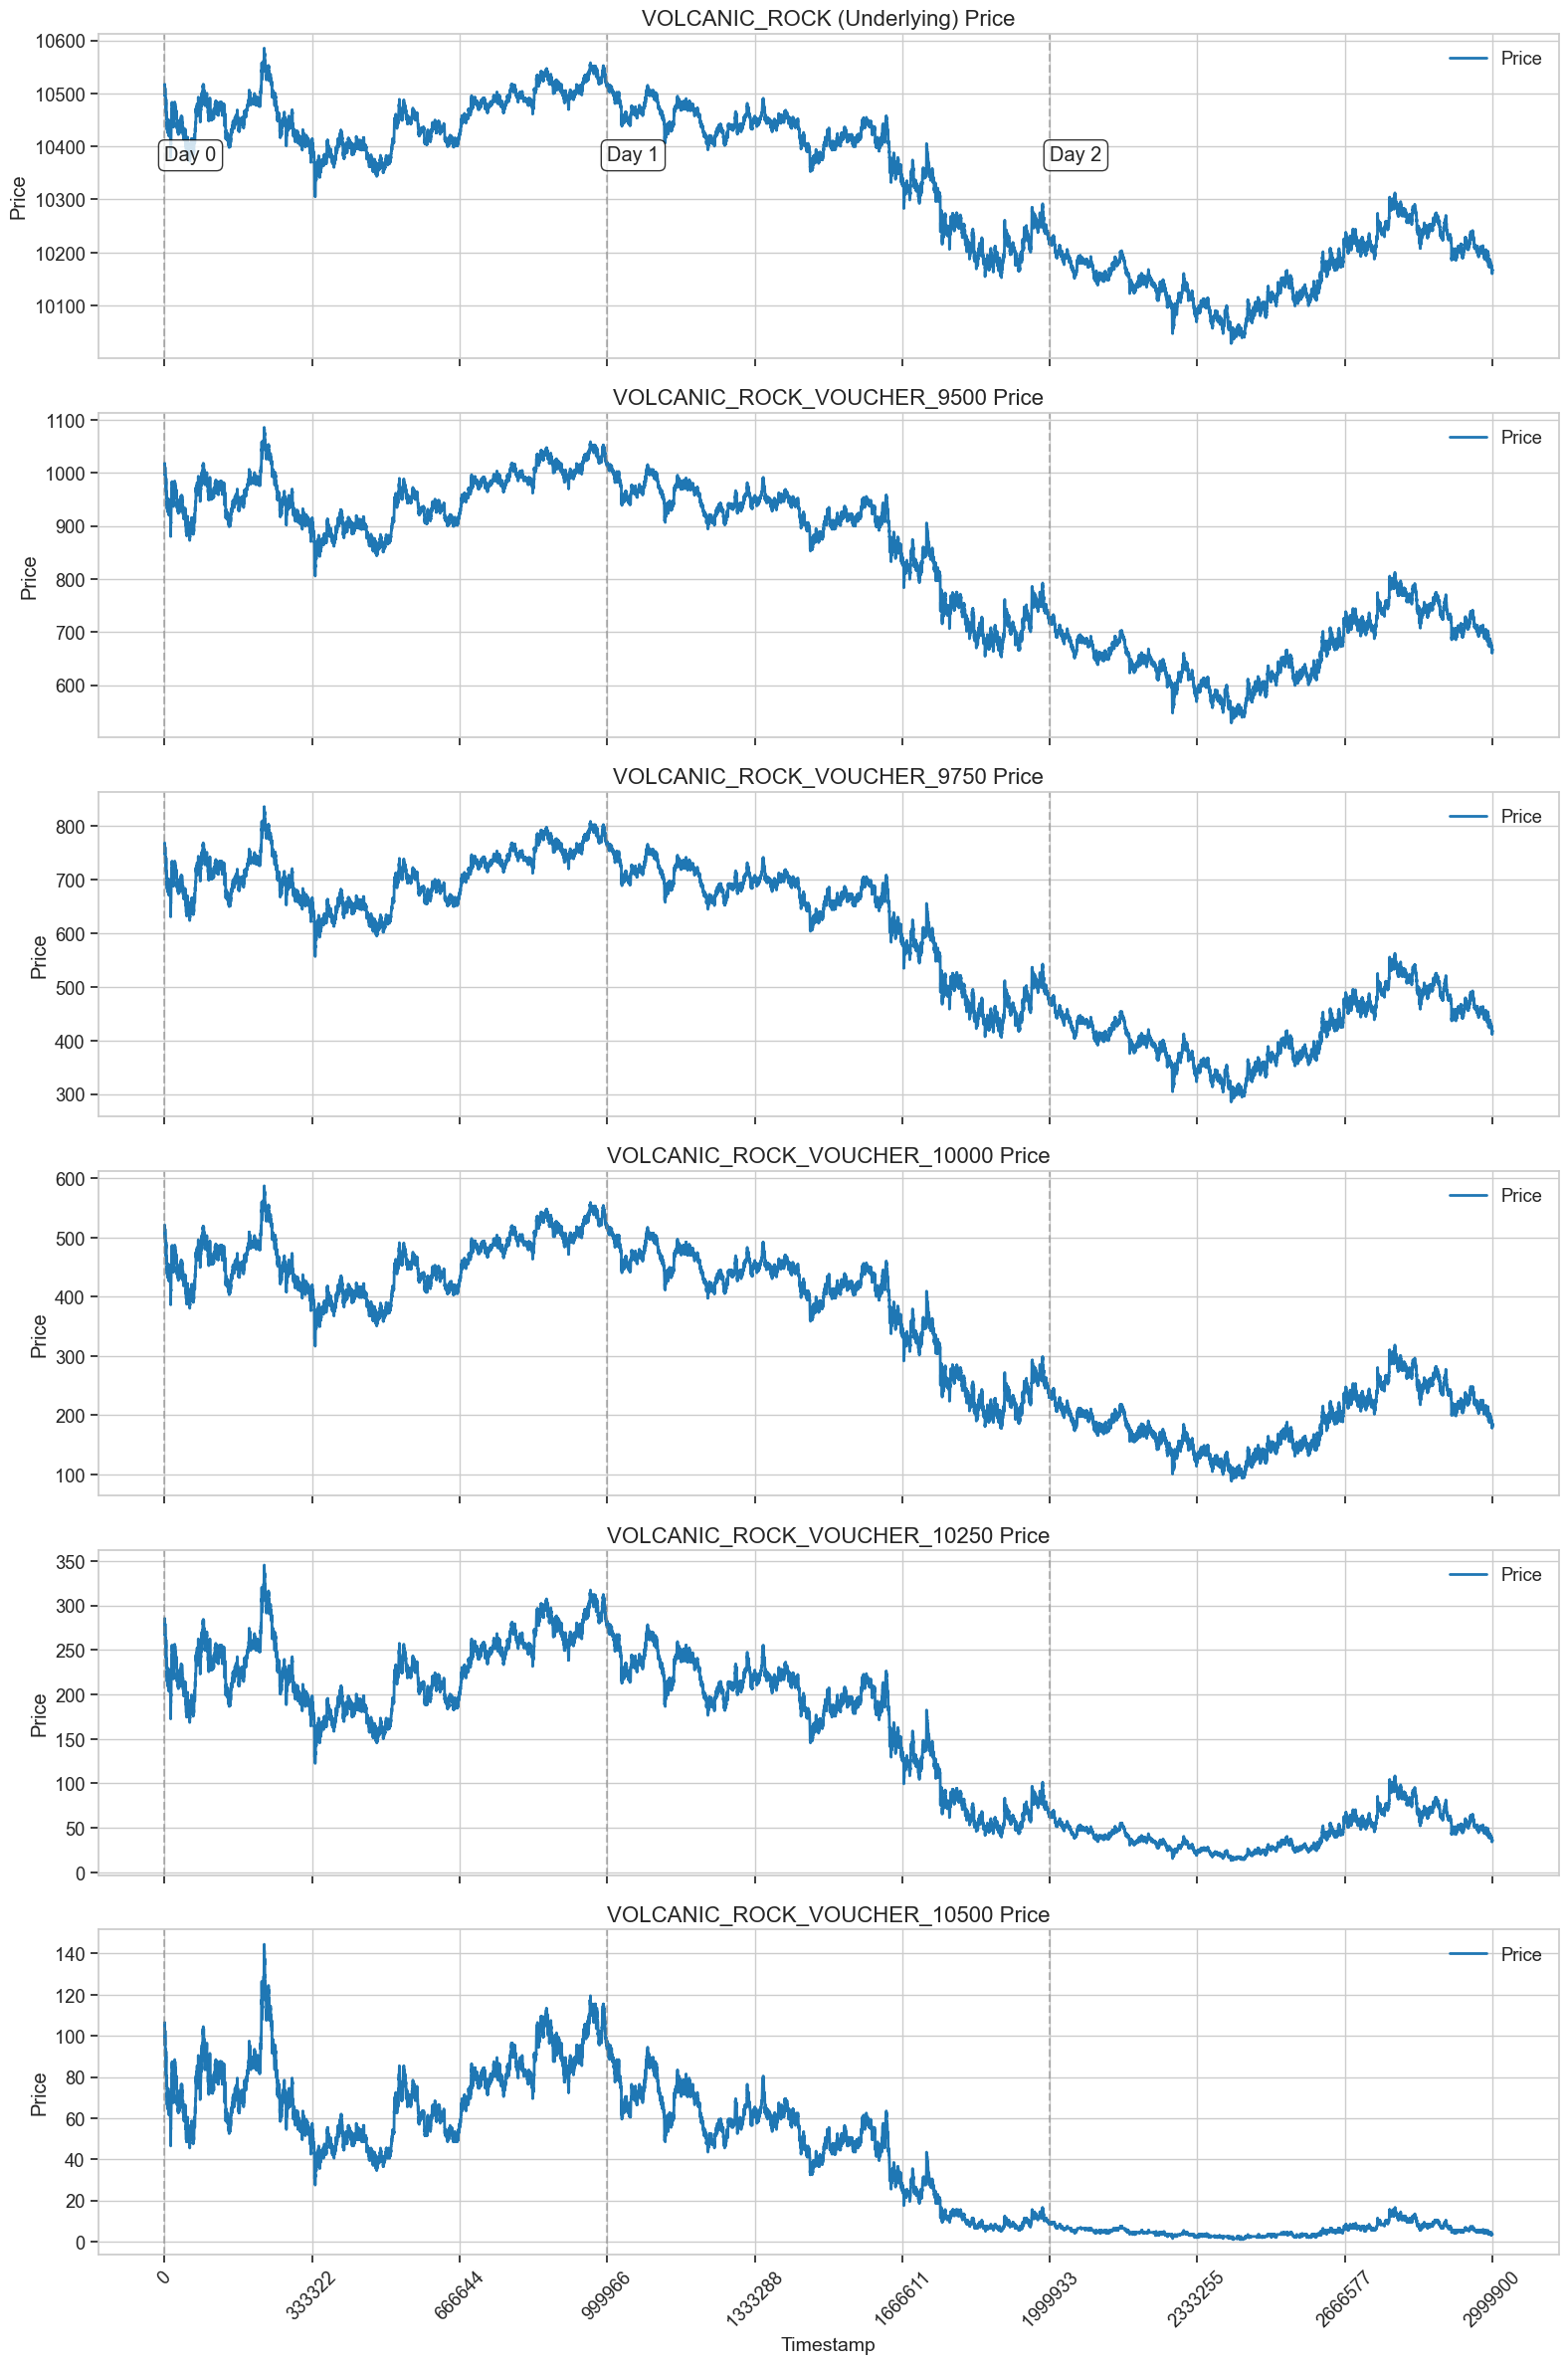

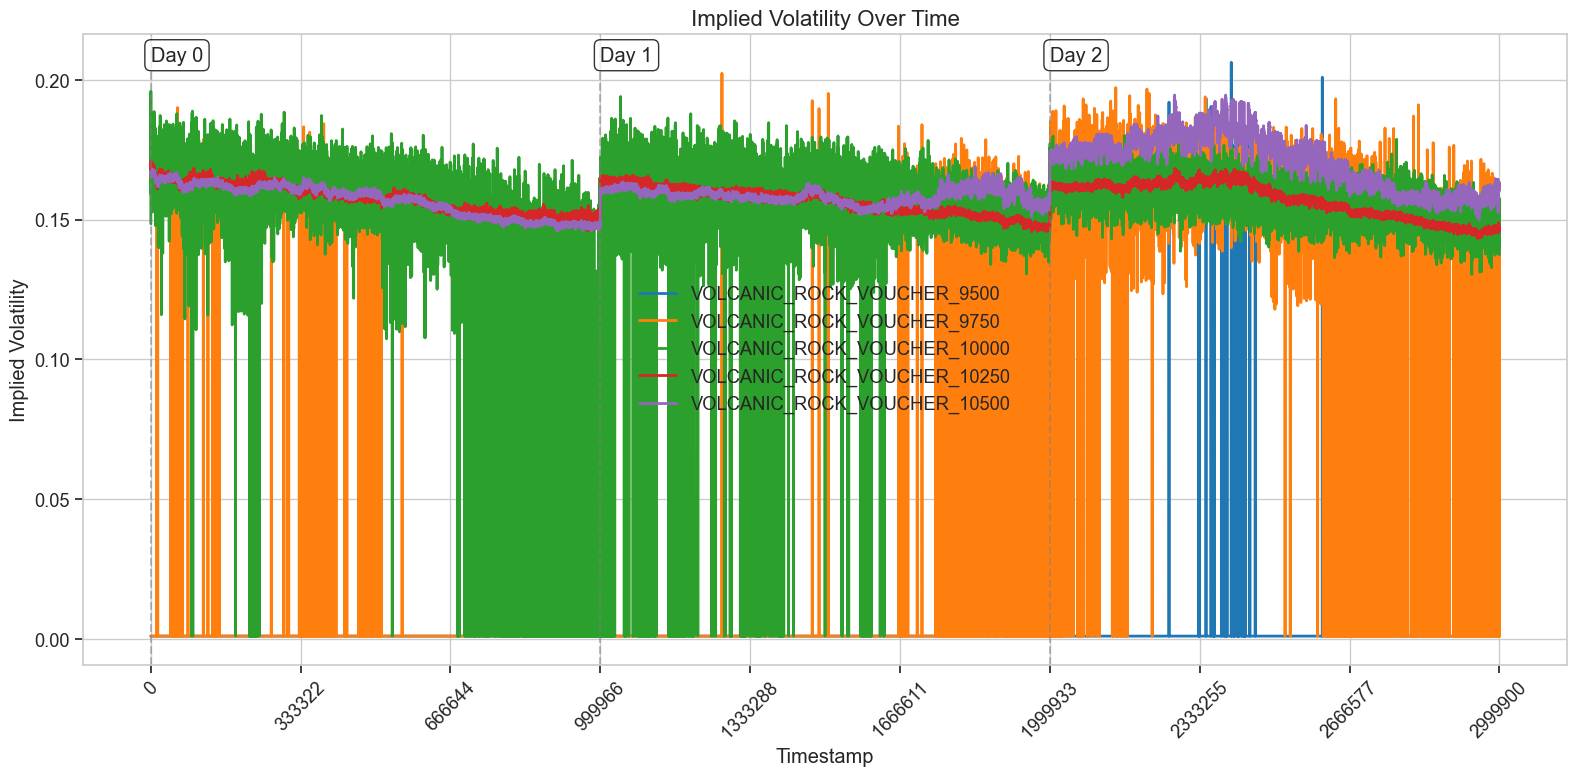

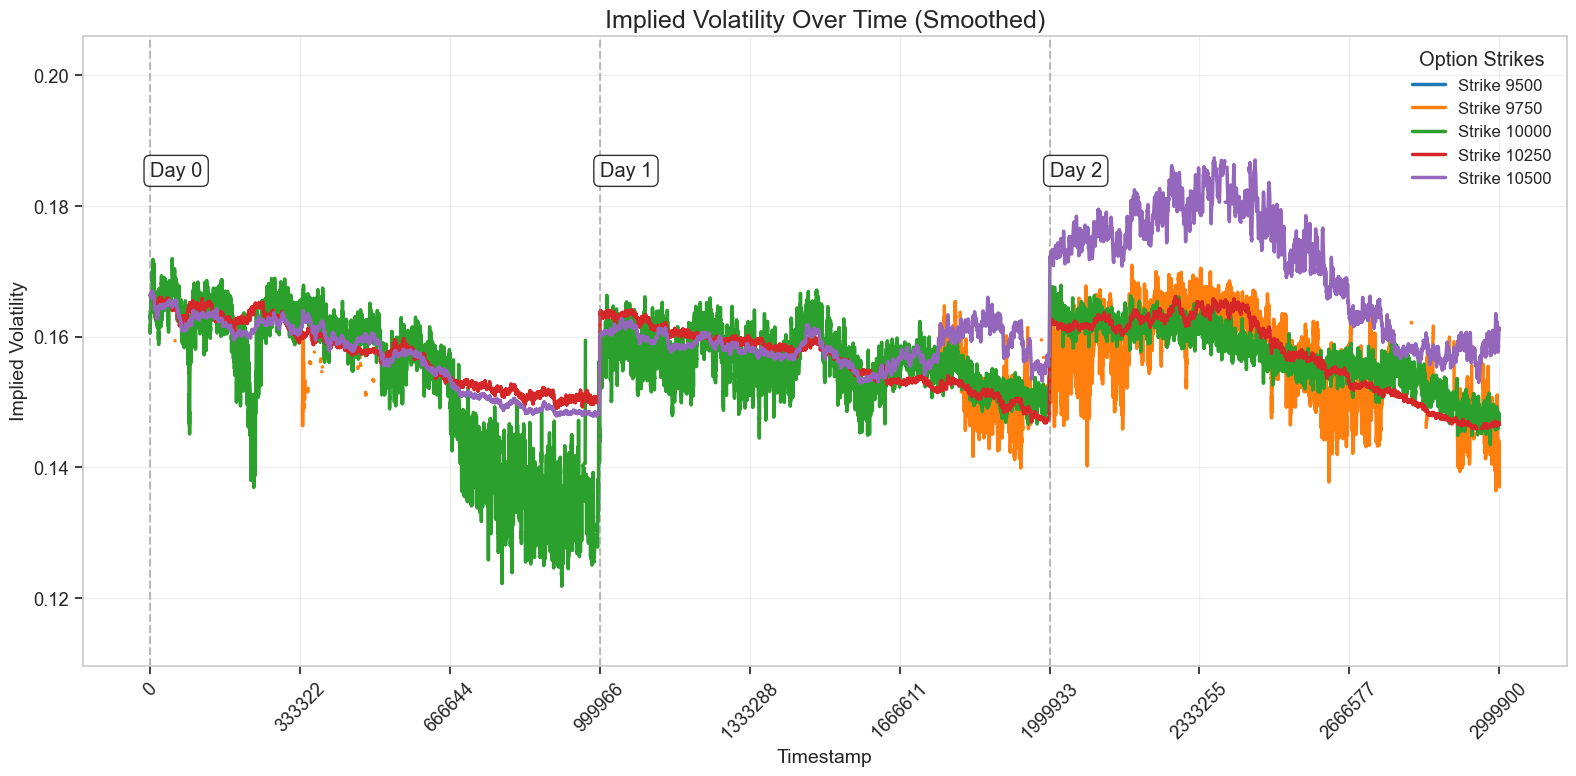

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
from scipy.stats import norm

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Function to load and preprocess data
def load_data(file_paths):
    """
    Load and preprocess CSV data from multiple files, adjusting timestamps for continuity
    """
    all_data = []
    day_offset = 0
    max_timestamp = 0
    
    for file_path in file_paths:
        data = pd.read_csv(file_path, sep=';')
        
        # If this isn't the first file, adjust timestamps for continuity
        if all_data:
            # Get the day number from the file
            day_num = data['day'].iloc[0]
            
            # Calculate timestamp offset to ensure continuity
            first_timestamp = data['timestamp'].min()
            
            # Add offset to make timestamps continuous
            if first_timestamp < max_timestamp:
                timestamp_offset = max_timestamp - first_timestamp + 100
                data['timestamp'] = data['timestamp'] + timestamp_offset
        
        # Track max timestamp for next file
        max_timestamp = max(data['timestamp'].max(), max_timestamp)
        
        all_data.append(data)
    
    # Combine all data
    combined_data = pd.concat(all_data)
    
    # Convert timestamp to numeric for calculations
    combined_data['timestamp'] = pd.to_numeric(combined_data['timestamp'])
    
    # Sort by timestamp
    combined_data = combined_data.sort_values('timestamp')
    
    # Reset index for clean plotting
    combined_data = combined_data.reset_index(drop=True)
    
    print(f"Loaded {len(combined_data)} rows spanning {combined_data['day'].nunique()} trading days")
    
    return combined_data

# Function to extract product data
def extract_product_data(data, product_name):
    """
    Extract data for a specific product
    """
    product_data = data[data['product'] == product_name].copy()
    
    # Calculate mid prices where both bid and ask exist
    mask = (~product_data['bid_price_1'].isna()) & (~product_data['ask_price_1'].isna())
    product_data.loc[mask, 'calculated_mid'] = (
        product_data.loc[mask, 'bid_price_1'] + product_data.loc[mask, 'ask_price_1']
    ) / 2
    
    # Otherwise use the provided mid_price
    product_data['mid_price'] = product_data['calculated_mid'].fillna(product_data['mid_price'])
    
    return product_data

# Black-Scholes pricing functions
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate Black-Scholes price for a call option
    """
    if T <= 0:
        return max(0, S - K)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def calculate_implied_volatility(S, K, T, r, option_price, precision=0.00001, max_iterations=100):
    """
    Calculate implied volatility using bisection method
    """
    if option_price <= 0:
        return 0.0
    
    # For very short-dated options
    if T <= 0.01:
        intrinsic = max(0, S - K)
        if abs(option_price - intrinsic) < precision:
            return 0.1  # Return a small volatility
    
    # Intrinsic value check
    intrinsic = max(0, S - K)
    if option_price < intrinsic:
        option_price = intrinsic + 0.01  # Adjust for calculation
    
    # Initial volatility range
    sigma_low = 0.001
    sigma_high = 5.0
    
    price_low = black_scholes_call(S, K, T, r, sigma_low)
    price_high = black_scholes_call(S, K, T, r, sigma_high)
    
    # Check if the price is outside our initial volatility range
    if option_price <= price_low:
        return sigma_low
    if option_price >= price_high:
        return sigma_high
    
    # Bisection search
    for i in range(max_iterations):
        sigma_mid = (sigma_low + sigma_high) / 2
        price_mid = black_scholes_call(S, K, T, r, sigma_mid)
        
        if abs(price_mid - option_price) < precision:
            return sigma_mid
        
        if price_mid < option_price:
            sigma_low = sigma_mid
        else:
            sigma_high = sigma_mid
    
    return (sigma_low + sigma_high) / 2

# 1. Plot price movements for all products
def plot_price_movements(data, voucher_products, days_data):
    """
    Plot price movements for underlying and all vouchers
    """
    fig, axes = plt.subplots(len(voucher_products) + 1, 1, figsize=(16, 4*(len(voucher_products) + 1)), sharex=True)
    
    # First plot underlying price
    underlying_data = extract_product_data(data, 'VOLCANIC_ROCK')
    axes[0].plot(underlying_data['timestamp'], underlying_data['mid_price'], label='Price', linewidth=2)
    axes[0].set_title('VOLCANIC_ROCK (Underlying) Price', fontsize=16)
    axes[0].set_ylabel('Price')
    axes[0].legend()
    
    # Plot each voucher price
    for i, product in enumerate(voucher_products):
        product_data = extract_product_data(data, product)
        axes[i+1].plot(product_data['timestamp'], product_data['mid_price'], label='Price', linewidth=2)
        axes[i+1].set_title(f'{product} Price', fontsize=16)
        axes[i+1].set_ylabel('Price')
        axes[i+1].legend()
    
    # Add day separators if we have multiple days
    if len(days_data) > 1:
        day_changes = []
        day_labels = []
        for day in range(0, max(data['day']) + 1):
            day_data = data[data['day'] == day]
            if not day_data.empty:
                first_timestamp = day_data['timestamp'].min()
                if not pd.isna(first_timestamp):
                    day_changes.append(first_timestamp)
                    day_labels.append(f"Day {day}")
        
        for ax in axes:
            for idx, ts in enumerate(day_changes):
                ax.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
                # Add day label at the top of the first plot
                if ax == axes[0]:
                    ax.text(ts + 100, ax.get_ylim()[1] * 0.98, day_labels[idx], 
                            verticalalignment='top', horizontalalignment='left',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add proper x-axis labeling
    axes[-1].set_xlabel('Timestamp', fontsize=14)
    
    # Add custom x-ticks at regular intervals
    tick_count = 10
    tick_positions = np.linspace(data['timestamp'].min(), data['timestamp'].max(), tick_count)
    tick_labels = [f"{int(ts)}" for ts in tick_positions]
    
    axes[-1].set_xticks(tick_positions)
    axes[-1].set_xticklabels(tick_labels, rotation=45)
    
    plt.tight_layout()
    return fig


# 2. Calculate and plot implied volatility for each voucher
def calculate_iv_data(data, voucher_products, strike_prices, risk_free_rate=0.01):
    """
    Calculate implied volatility for all vouchers at each timestamp
    """
    # Get all unique timestamps
    timestamps = data['timestamp'].unique()
    timestamps.sort()  # Ensure timestamps are sorted
    
    # Create a dataframe to store IVs
    iv_data = pd.DataFrame({'timestamp': timestamps})
    
    # Get underlying price at each timestamp
    underlying_data = extract_product_data(data, 'VOLCANIC_ROCK')
    timestamp_to_price = dict(zip(underlying_data['timestamp'], underlying_data['mid_price']))
    
    # Create a mapping from timestamp to day
    timestamp_to_day = {}
    for _, row in data.drop_duplicates(['timestamp', 'day']).iterrows():
        timestamp_to_day[row['timestamp']] = row['day']
    
    # Add day information to iv_data
    iv_data['day'] = iv_data['timestamp'].map(timestamp_to_day)
    
    # Calculate days to expiry
    iv_data['days_to_expiry'] = 7 - iv_data['day']
    
    # Calculate time to expiry in years (assuming 365 days in a year)
    iv_data['time_to_expiry'] = iv_data['days_to_expiry'] / 365.0
    
    # For each voucher, calculate IV
    for product in voucher_products:
        strike = strike_prices[product]
        product_data = extract_product_data(data, product)
        
        # Create a dictionary mapping timestamps to voucher prices
        timestamp_to_voucher_price = dict(zip(product_data['timestamp'], product_data['mid_price']))
        
        # Calculate IV for each timestamp
        ivs = []
        moneyness_vals = []
        
        for ts in timestamps:
            if ts in timestamp_to_price and ts in timestamp_to_voucher_price:
                S = timestamp_to_price[ts]
                option_price = timestamp_to_voucher_price[ts]
                T = iv_data.loc[iv_data['timestamp'] == ts, 'time_to_expiry'].values[0]
                
                # Calculate moneyness
                if T > 0:
                    moneyness = np.log(strike / S) / np.sqrt(T)
                    moneyness_vals.append(moneyness)
                    
                    try:
                        iv = calculate_implied_volatility(S, strike, T, risk_free_rate, option_price)
                        ivs.append(iv)
                    except Exception as e:
                        print(f"Error calculating IV for {product} at timestamp {ts}: {e}")
                        ivs.append(np.nan)
                        moneyness_vals.append(np.nan)
                else:
                    ivs.append(np.nan)
                    moneyness_vals.append(np.nan)
            else:
                ivs.append(np.nan)
                moneyness_vals.append(np.nan)
        
        iv_data[f'{product}_iv'] = ivs
        iv_data[f'{product}_moneyness'] = moneyness_vals
    
    return iv_data


# You also need to update the plot_implied_volatility function 
# to better handle the day separators:

def plot_implied_volatility(iv_data, voucher_products):
    """
    Plot implied volatility over time for each voucher
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for product in voucher_products:
        ax.plot(iv_data['timestamp'], iv_data[f'{product}_iv'], label=product, linewidth=2)
    
    ax.set_title('Implied Volatility Over Time', fontsize=16)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Implied Volatility')
    ax.legend()
    
    # Add day separators if we have multiple days
    if len(iv_data['day'].unique()) > 1:
        day_changes = []
        day_labels = []
        
        for day in sorted(iv_data['day'].unique()):
            day_data = iv_data[iv_data['day'] == day]
            if not day_data.empty:
                first_timestamp = day_data['timestamp'].min()
                if not pd.isna(first_timestamp):
                    day_changes.append(first_timestamp)
                    day_labels.append(f"Day {day}")
        
        for idx, ts in enumerate(day_changes):
            ax.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
            ax.text(ts + 100, ax.get_ylim()[1] * 0.98, day_labels[idx], 
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add custom x-ticks at regular intervals
    tick_count = 10
    tick_positions = np.linspace(iv_data['timestamp'].min(), iv_data['timestamp'].max(), tick_count)
    tick_labels = [f"{int(ts)}" for ts in tick_positions]
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45)
    
    plt.tight_layout()
    return fig


def plot_implied_volatility_improved(iv_data, voucher_products):
    """
    Plot implied volatility over time for each voucher with improved readability
    - Applies moving average to smooth the data
    - Filters out extreme outliers
    - Applies consistent color scheme
    - Improves legend and layout
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from scipy import stats
    
    # Create a clean copy of the data for plotting
    plot_data = iv_data.copy()
    
    # Apply filtering for each product's IV
    for product in voucher_products:
        col = f'{product}_iv'
        
        # First remove extreme outliers (values outside 3 standard deviations)
        valid_data = plot_data[col].dropna()
        if len(valid_data) > 0:
            # Use more robust filtering with winsorization
            lower_bound, upper_bound = stats.mstats.winsorize(valid_data, limits=[0.01, 0.01]).min(), stats.mstats.winsorize(valid_data, limits=[0.01, 0.01]).max()
            
            # Apply reasonable limits for implied volatility
            lower_limit = max(0.01, lower_bound)  # IV shouldn't be less than 1%
            upper_limit = min(0.5, upper_bound)   # IV shouldn't be more than 50%
            
            # Apply filtering
            plot_data.loc[plot_data[col] < lower_limit, col] = np.nan
            plot_data.loc[plot_data[col] > upper_limit, col] = np.nan
        
        # Apply moving average smoothing
        window_size = 15  # Adjust window size as needed
        plot_data[f'{col}_smooth'] = plot_data[col].rolling(window=window_size, center=True, min_periods=3).mean()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Define a nice color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot each product's smoothed IV
    for i, product in enumerate(voucher_products):
        col = f'{product}_iv_smooth'
        ax.plot(plot_data['timestamp'], plot_data[col], 
                label=product.replace('VOLCANIC_ROCK_VOUCHER_', 'Strike '), 
                linewidth=2.5, 
                color=colors[i % len(colors)])
    
    # Add day separators
    if len(plot_data['day'].unique()) > 1:
        day_changes = []
        day_labels = []
        
        for day in sorted(plot_data['day'].unique()):
            day_data = plot_data[plot_data['day'] == day]
            if not day_data.empty:
                first_timestamp = day_data['timestamp'].min()
                if not pd.isna(first_timestamp):
                    day_changes.append(first_timestamp)
                    day_labels.append(f"Day {day}")
        
        for idx, ts in enumerate(day_changes):
            ax.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
            ax.text(ts + 100, ax.get_ylim()[1] * 0.98, day_labels[idx], 
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Improve legend
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9, title="Option Strikes")
    
    # Set title and labels
    ax.set_title('Implied Volatility Over Time (Smoothed)', fontsize=18)
    ax.set_xlabel('Timestamp', fontsize=14)
    ax.set_ylabel('Implied Volatility', fontsize=14)
    
    # Set y-axis limits more appropriately
    y_min = max(0, plot_data[[f'{p}_iv_smooth' for p in voucher_products]].min().min() * 0.9)
    y_max = plot_data[[f'{p}_iv_smooth' for p in voucher_products]].max().max() * 1.1
    ax.set_ylim(y_min, y_max)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add custom x-ticks at regular intervals
    tick_count = 10
    tick_positions = np.linspace(plot_data['timestamp'].min(), plot_data['timestamp'].max(), tick_count)
    tick_labels = [f"{int(ts)}" for ts in tick_positions]
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45)
    
    plt.tight_layout()
    return fig

# 3. Plot volatility smile
def plot_volatility_smile(iv_data, voucher_products, timestamps=None):
    """
    Plot the volatility smile at selected timestamps
    """
    if timestamps is None:
        # If no timestamps provided, pick a few representative ones
        num_days = iv_data['day'].nunique()
        timestamps = []
        for day in iv_data['day'].unique():
            # Get timestamps at beginning, middle and end of each day
            day_data = iv_data[iv_data['day'] == day]
            day_timestamps = day_data['timestamp'].sort_values()
            if len(day_timestamps) > 0:
                timestamps.append(day_timestamps.iloc[0])  # Beginning
                if len(day_timestamps) > 2:
                    timestamps.append(day_timestamps.iloc[len(day_timestamps)//2])  # Middle
                timestamps.append(day_timestamps.iloc[-1])  # End
    
    fig, axes = plt.subplots(len(timestamps), 1, figsize=(12, 5*len(timestamps)))
    if len(timestamps) == 1:
        axes = [axes]
    
    for i, ts in enumerate(timestamps):
        ts_data = iv_data[iv_data['timestamp'] == ts]
        
        if ts_data.empty:
            continue
        
        x_points = []
        y_points = []
        labels = []
        
        for product in voucher_products:
            moneyness = ts_data[f'{product}_moneyness'].values[0]
            iv = ts_data[f'{product}_iv'].values[0]
            
            if not np.isnan(moneyness) and not np.isnan(iv):
                x_points.append(moneyness)
                y_points.append(iv)
                labels.append(product)
        
        if len(x_points) > 2:  # Need at least 3 points for quadratic fit
            # Sort by moneyness for plotting
            sort_idx = np.argsort(x_points)
            x_points = np.array(x_points)[sort_idx]
            y_points = np.array(y_points)[sort_idx]
            labels = np.array(labels)[sort_idx]
            
            # Plot points
            axes[i].scatter(x_points, y_points, s=100)
            
            # Add labels
            for j, label in enumerate(labels):
                axes[i].annotate(label, (x_points[j], y_points[j]), 
                             textcoords="offset points", 
                             xytext=(0,10), 
                             ha='center')
            
            # Fit quadratic curve
            try:
                z = np.polyfit(x_points, y_points, 2)
                p = np.poly1d(z)
                
                # Generate x values for smooth curve
                x_curve = np.linspace(min(x_points) - 0.2, max(x_points) + 0.2, 100)
                
                # Plot fitted curve
                axes[i].plot(x_curve, p(x_curve), 'r--')
                
                # Add equation to the plot
                eq_text = f"IV = {z[0]:.4f}x² + {z[1]:.4f}x + {z[2]:.4f}"
                axes[i].text(0.05, 0.95, eq_text, transform=axes[i].transAxes, 
                         fontsize=12, verticalalignment='top', 
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            except:
                pass  # Skip curve fitting if it fails
        
        axes[i].set_title(f'Volatility Smile at Timestamp {ts} (Day {ts_data["day"].values[0]})', fontsize=14)
        axes[i].set_xlabel('Moneyness = ln(K/S)/sqrt(T)')
        axes[i].set_ylabel('Implied Volatility')
        axes[i].grid(True)
    
    plt.tight_layout()
    return fig

# 4. Plot theoretical vs market prices
def calculate_theoretical_prices(data, voucher_products, strike_prices, risk_free_rate=0.01):
    """
    Calculate theoretical prices using Black-Scholes and compare to market prices
    """
    # Get all unique timestamps
    timestamps = data['timestamp'].unique()
    timestamps.sort()  # Ensure timestamps are sorted
    
    # Create a dataframe to store prices
    price_data = pd.DataFrame({'timestamp': timestamps})
    
    # Get underlying price at each timestamp
    underlying_data = extract_product_data(data, 'VOLCANIC_ROCK')
    timestamp_to_price = dict(zip(underlying_data['timestamp'], underlying_data['mid_price']))
    
    # Create a mapping from timestamp to day
    timestamp_to_day = {}
    for _, row in data.drop_duplicates(['timestamp', 'day']).iterrows():
        timestamp_to_day[row['timestamp']] = row['day']
    
    # Add day information to price_data using the mapping
    price_data['day'] = price_data['timestamp'].map(timestamp_to_day)
    
    # Calculate days to expiry
    price_data['days_to_expiry'] = 7 - price_data['day']
    price_data['time_to_expiry'] = price_data['days_to_expiry'] / 365.0
    
    # Calculate IV data first
    iv_data = calculate_iv_data(data, voucher_products, strike_prices, risk_free_rate)
    
    # Create a mapping from timestamp to average IV
    timestamp_to_avg_iv = {}
    for idx, row in iv_data.iterrows():
        ts = row['timestamp']
        ivs = []
        for product in voucher_products:
            iv = row[f'{product}_iv']
            if not np.isnan(iv):
                ivs.append(iv)
        
        if ivs:
            timestamp_to_avg_iv[ts] = np.mean(ivs)
        else:
            timestamp_to_avg_iv[ts] = 0.25  # Default if no IV
    
    # Add average IV to price_data
    price_data['avg_iv'] = price_data['timestamp'].map(timestamp_to_avg_iv)
    
    # For each voucher, calculate theoretical and get market prices
    for product in voucher_products:
        strike = strike_prices[product]
        product_data = extract_product_data(data, product)
        
        # Create a dictionary mapping timestamps to voucher prices
        timestamp_to_voucher_price = dict(zip(product_data['timestamp'], product_data['mid_price']))
        
        # Calculate theoretical price and get market price for each timestamp
        theo_prices = []
        market_prices = []
        
        for ts in timestamps:
            if ts in timestamp_to_price:
                S = timestamp_to_price[ts]
                T_row = price_data[price_data['timestamp'] == ts]
                
                if not T_row.empty and not np.isnan(T_row['time_to_expiry'].values[0]):
                    T = T_row['time_to_expiry'].values[0]
                    iv = T_row['avg_iv'].values[0]
                    
                    # Calculate theoretical price
                    if T > 0:
                        theo_price = black_scholes_call(S, strike, T, risk_free_rate, iv)
                    else:
                        theo_price = max(0, S - strike)  # Intrinsic value at expiry
                    
                    theo_prices.append(theo_price)
                    
                    # Get market price
                    if ts in timestamp_to_voucher_price:
                        market_prices.append(timestamp_to_voucher_price[ts])
                    else:
                        market_prices.append(np.nan)
                else:
                    theo_prices.append(np.nan)
                    market_prices.append(np.nan)
            else:
                theo_prices.append(np.nan)
                market_prices.append(np.nan)
        
        price_data[f'{product}_theo'] = theo_prices
        price_data[f'{product}_market'] = market_prices
        price_data[f'{product}_diff'] = price_data[f'{product}_market'] - price_data[f'{product}_theo']
    
    return price_data


def plot_theoretical_vs_market(price_data, voucher_products):
    """
    Plot theoretical vs market prices for each voucher
    """
    fig, axes = plt.subplots(len(voucher_products), 1, figsize=(16, 5*len(voucher_products)), sharex=True)
    
    if len(voucher_products) == 1:
        axes = [axes]
    
    for i, product in enumerate(voucher_products):
        axes[i].plot(price_data['timestamp'], price_data[f'{product}_market'], 'b-', label='Market Price', linewidth=2)
        axes[i].plot(price_data['timestamp'], price_data[f'{product}_theo'], 'r--', label='Theoretical Price', linewidth=2)
        axes[i].set_title(f'{product} - Market vs Theoretical Price', fontsize=16)
        axes[i].set_ylabel('Price')
        axes[i].legend()
        
        # Add secondary axis for price difference
        ax2 = axes[i].twinx()
        ax2.plot(price_data['timestamp'], price_data[f'{product}_diff'], 'g-', label='Difference', alpha=0.5)
        ax2.set_ylabel('Price Difference', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Add day separators if we have multiple days
    if len(price_data['day'].unique()) > 1:
        day_changes = []
        for day in range(1, price_data['day'].max() + 1):
            first_timestamp = price_data[price_data['day'] == day]['timestamp'].min()
            if not pd.isna(first_timestamp):
                day_changes.append(first_timestamp)
        
        for ax in axes:
            for ts in day_changes:
                ax.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
    
    plt.xlabel('Timestamp')
    plt.tight_layout()
    return fig


def plot_theoretical_vs_market_improved(price_data, voucher_products):
    """
    Plot theoretical vs market prices for each voucher with improved readability
    """
    fig, axes = plt.subplots(len(voucher_products), 1, figsize=(16, 5*len(voucher_products)), sharex=True)
    
    if len(voucher_products) == 1:
        axes = [axes]
    
    # Define a nice color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, product in enumerate(voucher_products):
        # Apply moving average to smooth the data
        window_size = 15
        price_data[f'{product}_theo_smooth'] = price_data[f'{product}_theo'].rolling(
            window=window_size, center=True, min_periods=3).mean()
        price_data[f'{product}_market_smooth'] = price_data[f'{product}_market'].rolling(
            window=window_size, center=True, min_periods=3).mean()
        price_data[f'{product}_diff_smooth'] = price_data[f'{product}_diff'].rolling(
            window=window_size, center=True, min_periods=3).mean()
        
        # Plot market price
        axes[i].plot(price_data['timestamp'], price_data[f'{product}_market_smooth'], 
                    'b-', label='Market Price', linewidth=2.5)
        
        # Plot theoretical price
        axes[i].plot(price_data['timestamp'], price_data[f'{product}_theo_smooth'], 
                    'r--', label='Theoretical Price', linewidth=2.5)
        
        # Format title to show the strike
        strike = product.replace('VOLCANIC_ROCK_VOUCHER_', '')
        axes[i].set_title(f'Strike {strike} - Market vs Theoretical Price', fontsize=16)
        axes[i].set_ylabel('Price')
        axes[i].legend(loc='upper left')
        
        # Add secondary axis for price difference
        ax2 = axes[i].twinx()
        ax2.plot(price_data['timestamp'], price_data[f'{product}_diff_smooth'], 
                'g-', label='Difference', alpha=0.7, linewidth=2)
        ax2.set_ylabel('Price Difference', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Add legend for secondary axis
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines2, labels2, loc='upper right')
    
    # Add day separators
    if len(price_data['day'].unique()) > 1:
        day_changes = []
        day_labels = []
        
        for day in sorted(price_data['day'].unique()):
            day_data = price_data[price_data['day'] == day]
            if not day_data.empty:
                first_timestamp = day_data['timestamp'].min()
                if not pd.isna(first_timestamp):
                    day_changes.append(first_timestamp)
                    day_labels.append(f"Day {day}")
        
        for ax in axes:
            for idx, ts in enumerate(day_changes):
                ax.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
                ax.text(ts + 100, ax.get_ylim()[1] * 0.98, day_labels[idx], 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add proper x-axis labeling
    axes[-1].set_xlabel('Timestamp', fontsize=14)
    
    # Add custom x-ticks at regular intervals
    tick_count = 10
    tick_positions = np.linspace(price_data['timestamp'].min(), price_data['timestamp'].max(), tick_count)
    tick_labels = [f"{int(ts)}" for ts in tick_positions]
    
    axes[-1].set_xticks(tick_positions)
    axes[-1].set_xticklabels(tick_labels, rotation=45)
    
    plt.tight_layout()
    return fig

# 5. Plot trading opportunities
def identify_trading_opportunities(price_data, voucher_products, threshold_pct=0.05):
    """
    Identify potential trading opportunities based on price differences
    """
    opportunity_data = price_data.copy()
    
    for product in voucher_products:
        # Calculate percentage difference
        opportunity_data[f'{product}_pct_diff'] = (
            opportunity_data[f'{product}_market'] - opportunity_data[f'{product}_theo']
        ) / opportunity_data[f'{product}_theo']
        
        # Identify buying and selling opportunities
        opportunity_data[f'{product}_buy_signal'] = opportunity_data[f'{product}_pct_diff'] < -threshold_pct
        opportunity_data[f'{product}_sell_signal'] = opportunity_data[f'{product}_pct_diff'] > threshold_pct
    
    return opportunity_data

def plot_trading_opportunities(opportunity_data, voucher_products, threshold_pct=0.05):
    """
    Plot price differences and highlight trading opportunities
    """
    fig, axes = plt.subplots(len(voucher_products), 1, figsize=(16, 5*len(voucher_products)), sharex=True)
    
    if len(voucher_products) == 1:
        axes = [axes]
    
    for i, product in enumerate(voucher_products):
        # Plot percentage difference
        axes[i].plot(opportunity_data['timestamp'], opportunity_data[f'{product}_pct_diff'], 'b-', linewidth=2)
        
        # Highlight buying opportunities
        buy_data = opportunity_data[opportunity_data[f'{product}_buy_signal']]
        if not buy_data.empty:
            axes[i].scatter(buy_data['timestamp'], buy_data[f'{product}_pct_diff'], 
                         color='green', s=100, label='Buy Signal')
        
        # Highlight selling opportunities
        sell_data = opportunity_data[opportunity_data[f'{product}_sell_signal']]
        if not sell_data.empty:
            axes[i].scatter(sell_data['timestamp'], sell_data[f'{product}_pct_diff'], 
                         color='red', s=100, label='Sell Signal')
        
        # Add threshold lines
        axes[i].axhline(y=threshold_pct, color='red', linestyle='--', alpha=0.5)
        axes[i].axhline(y=-threshold_pct, color='green', linestyle='--', alpha=0.5)
        axes[i].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        axes[i].set_title(f'{product} - Trading Opportunities', fontsize=16)
        axes[i].set_ylabel('Price Difference (%)')
        axes[i].legend()
    
    # Add day separators if we have multiple days
    if len(opportunity_data['day'].unique()) > 1:
        day_changes = []
        for day in range(1, opportunity_data['day'].max() + 1):
            first_timestamp = opportunity_data[opportunity_data['day'] == day]['timestamp'].min()
            if not pd.isna(first_timestamp):
                day_changes.append(first_timestamp)
        
        for ax in axes:
            for ts in day_changes:
                ax.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
    
    plt.xlabel('Timestamp')
    plt.tight_layout()
    return fig

# 6. Simulate strategy performance
def simulate_strategy(data, voucher_products, strike_prices, threshold_pct=0.05):
    """
    Simulate a basic trading strategy based on price differences
    """
    # Calculate theoretical prices and identify opportunities
    price_data = calculate_theoretical_prices(data, voucher_products, strike_prices)
    opportunity_data = identify_trading_opportunities(price_data, voucher_products, threshold_pct)
    
    # Initialize portfolio
    portfolio = {
        'timestamp': opportunity_data['timestamp'].tolist(),
        'cash': [0] * len(opportunity_data),
        'positions': {},
        'position_values': {},
        'total_value': [0] * len(opportunity_data)
    }
    
    for product in voucher_products:
        portfolio['positions'][product] = [0] * len(opportunity_data)
        portfolio['position_values'][product] = [0] * len(opportunity_data)
    
    # Get product prices for valuation
    product_prices = {}
    for product in voucher_products + ['VOLCANIC_ROCK']:
        product_data = extract_product_data(data, product)
        product_prices[product] = dict(zip(product_data['timestamp'], product_data['mid_price']))
    
    # Simulate trading
    for i, ts in enumerate(opportunity_data['timestamp']):
        if i == 0:
            continue  # Skip first timestamp as we need prior data
        
        # Transfer previous positions and cash
        for product in voucher_products:
            portfolio['positions'][product][i] = portfolio['positions'][product][i-1]
        portfolio['cash'][i] = portfolio['cash'][i-1]
        
        # Check for trading signals
        for product in voucher_products:
            # Skip if price data is missing
            if np.isnan(opportunity_data.loc[i, f'{product}_pct_diff']):
                continue
            
            # Buy signal
            if opportunity_data.loc[i, f'{product}_buy_signal']:
                # Simulate buying the voucher
                if product in product_prices and ts in product_prices[product]:
                    price = product_prices[product][ts]
                    # Buy up to 10 units per signal (simplified)
                    quantity = 10
                    portfolio['positions'][product][i] += quantity
                    portfolio['cash'][i] -= price * quantity
            
            # Sell signal
            elif opportunity_data.loc[i, f'{product}_sell_signal']:
                # Simulate selling the voucher
                if product in product_prices and ts in product_prices[product]:
                    price = product_prices[product][ts]
                    # Sell up to 10 units per signal (simplified)
                    quantity = 10
                    portfolio['positions'][product][i] -= quantity
                    portfolio['cash'][i] += price * quantity
        
        # Calculate position values and total portfolio value
        for product in voucher_products:
            if product in product_prices and ts in product_prices[product]:
                price = product_prices[product][ts]
                portfolio['position_values'][product][i] = portfolio['positions'][product][i] * price
            else:
                portfolio['position_values'][product][i] = 0
        
        # Calculate total portfolio value
        portfolio['total_value'][i] = portfolio['cash'][i]
        for product in voucher_products:
            portfolio['total_value'][i] += portfolio['position_values'][product][i]
    
    return portfolio

def plot_strategy_performance(portfolio, voucher_products):
    """
    Plot strategy performance metrics
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    
    # Plot portfolio value
    axes[0].plot(portfolio['timestamp'], portfolio['total_value'], 'b-', linewidth=2)
    axes[0].set_title('Portfolio Value Over Time', fontsize=16)
    axes[0].set_ylabel('Value')
    
    # Plot positions
    for product in voucher_products:
        axes[1].plot(portfolio['timestamp'], portfolio['positions'][product], label=product)
    
    axes[1].set_title('Product Positions Over Time', fontsize=16)
    axes[1].set_ylabel('Position')
    axes[1].set_xlabel('Timestamp')
    axes[1].legend()
    
    plt.tight_layout()
    return fig

# Main execution flow for analyzing the strategy

# 1. Set up file paths and parameters
file_paths = [
    'data/prices_round_3_day_0.csv',
    'data/prices_round_3_day_1.csv',
    'data/prices_round_3_day_2.csv'
]

voucher_products = [
    'VOLCANIC_ROCK_VOUCHER_9500',
    'VOLCANIC_ROCK_VOUCHER_9750',
    'VOLCANIC_ROCK_VOUCHER_10000',
    'VOLCANIC_ROCK_VOUCHER_10250',
    'VOLCANIC_ROCK_VOUCHER_10500'
]

strike_prices = {
    'VOLCANIC_ROCK_VOUCHER_9500': 9500,
    'VOLCANIC_ROCK_VOUCHER_9750': 9750,
    'VOLCANIC_ROCK_VOUCHER_10000': 10000,
    'VOLCANIC_ROCK_VOUCHER_10250': 10250,
    'VOLCANIC_ROCK_VOUCHER_10500': 10500
}

# Load and preprocess data
data = load_data(file_paths)

# 1. Plot price movements
price_fig = plot_price_movements(data, voucher_products, range(data['day'].nunique()))

# 2. Calculate IV data and plot implied volatility
iv_data = calculate_iv_data(data, voucher_products, strike_prices)
iv_fig = plot_implied_volatility(iv_data, voucher_products)
# Create the improved visualization
improved_iv_fig = plot_implied_volatility_improved(iv_data, voucher_products)

# Optional: view the side-by-side comparison
# comparison_fig = compare_iv_plots(iv_data, voucher_products)

# iv_fig.savefig('implied_volatility.png')



/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_99098/985642947.py:875: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


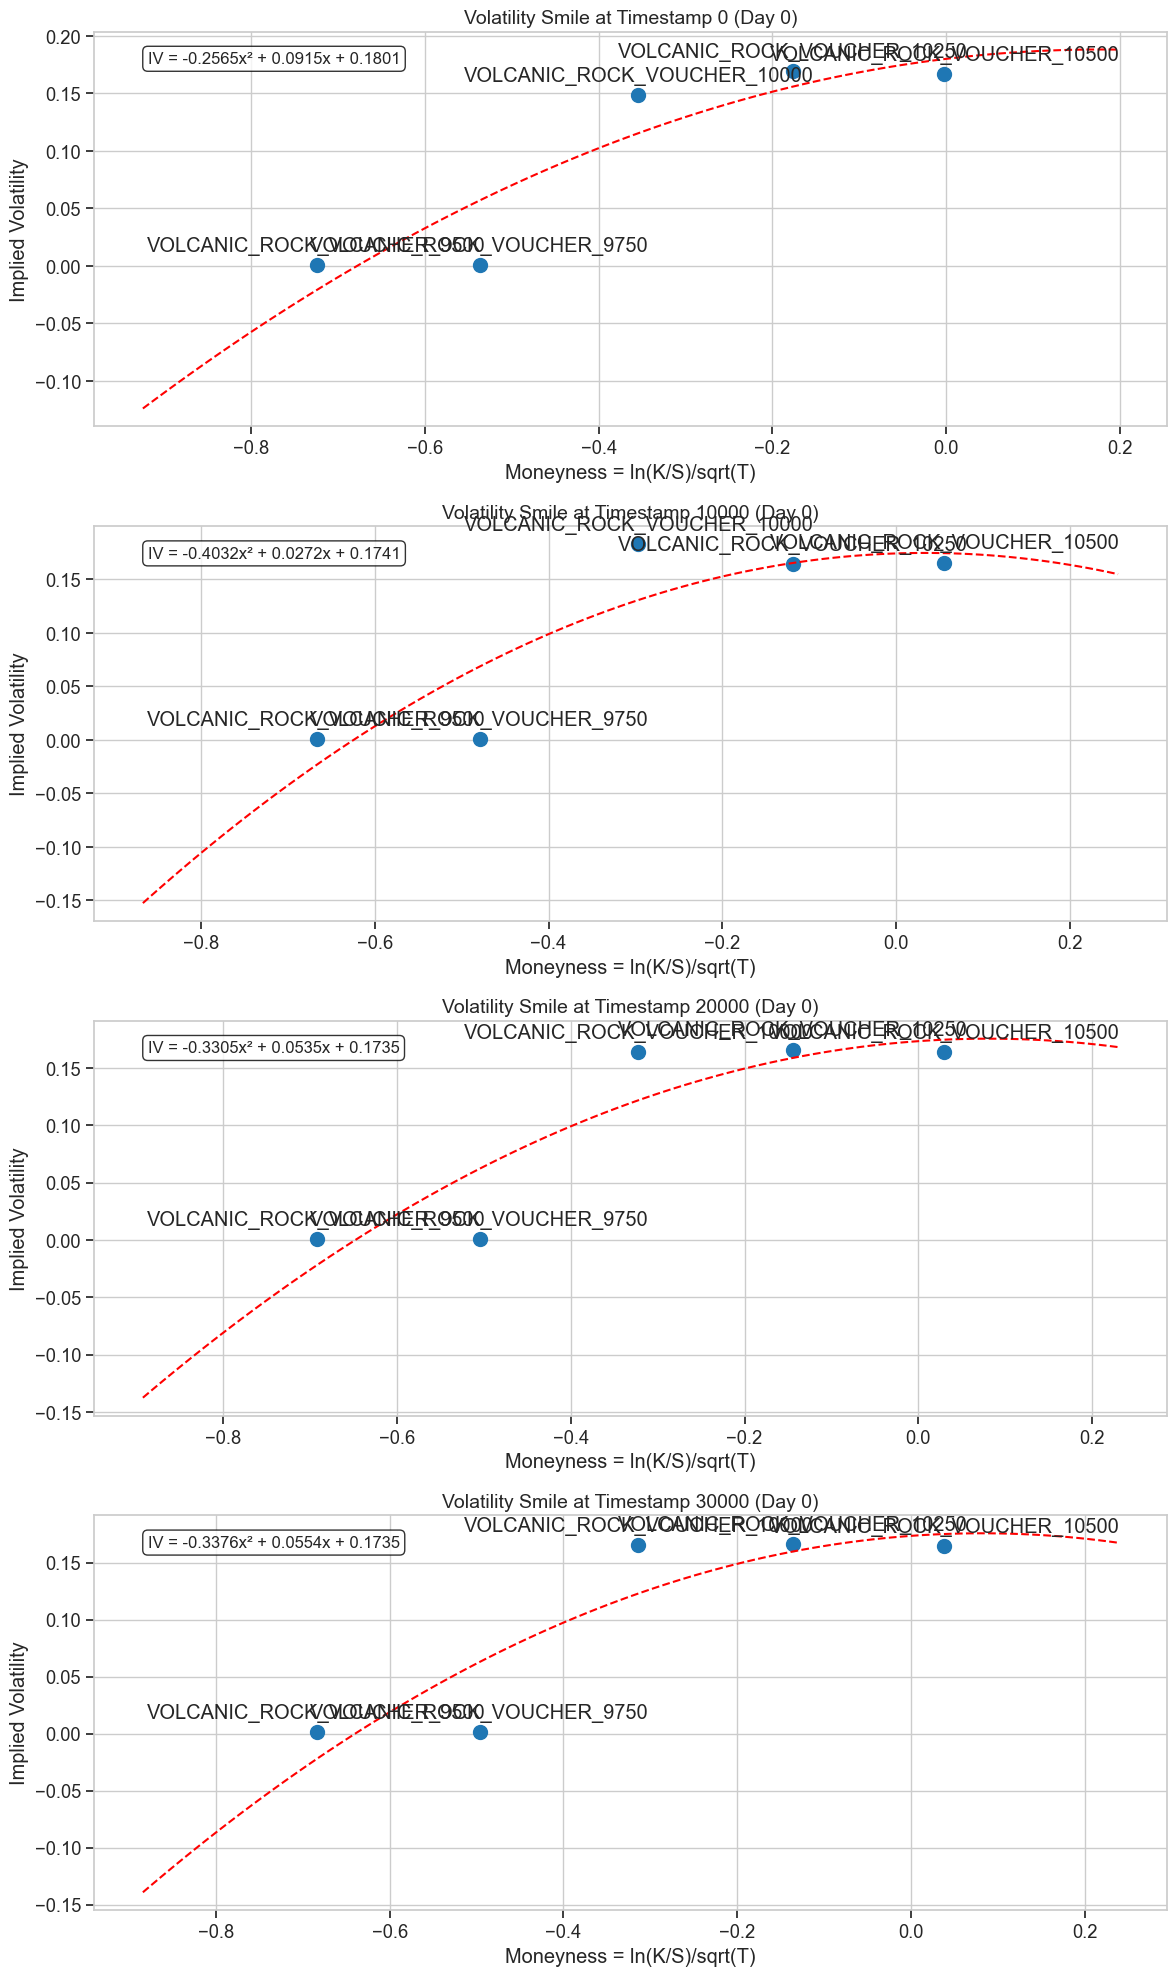

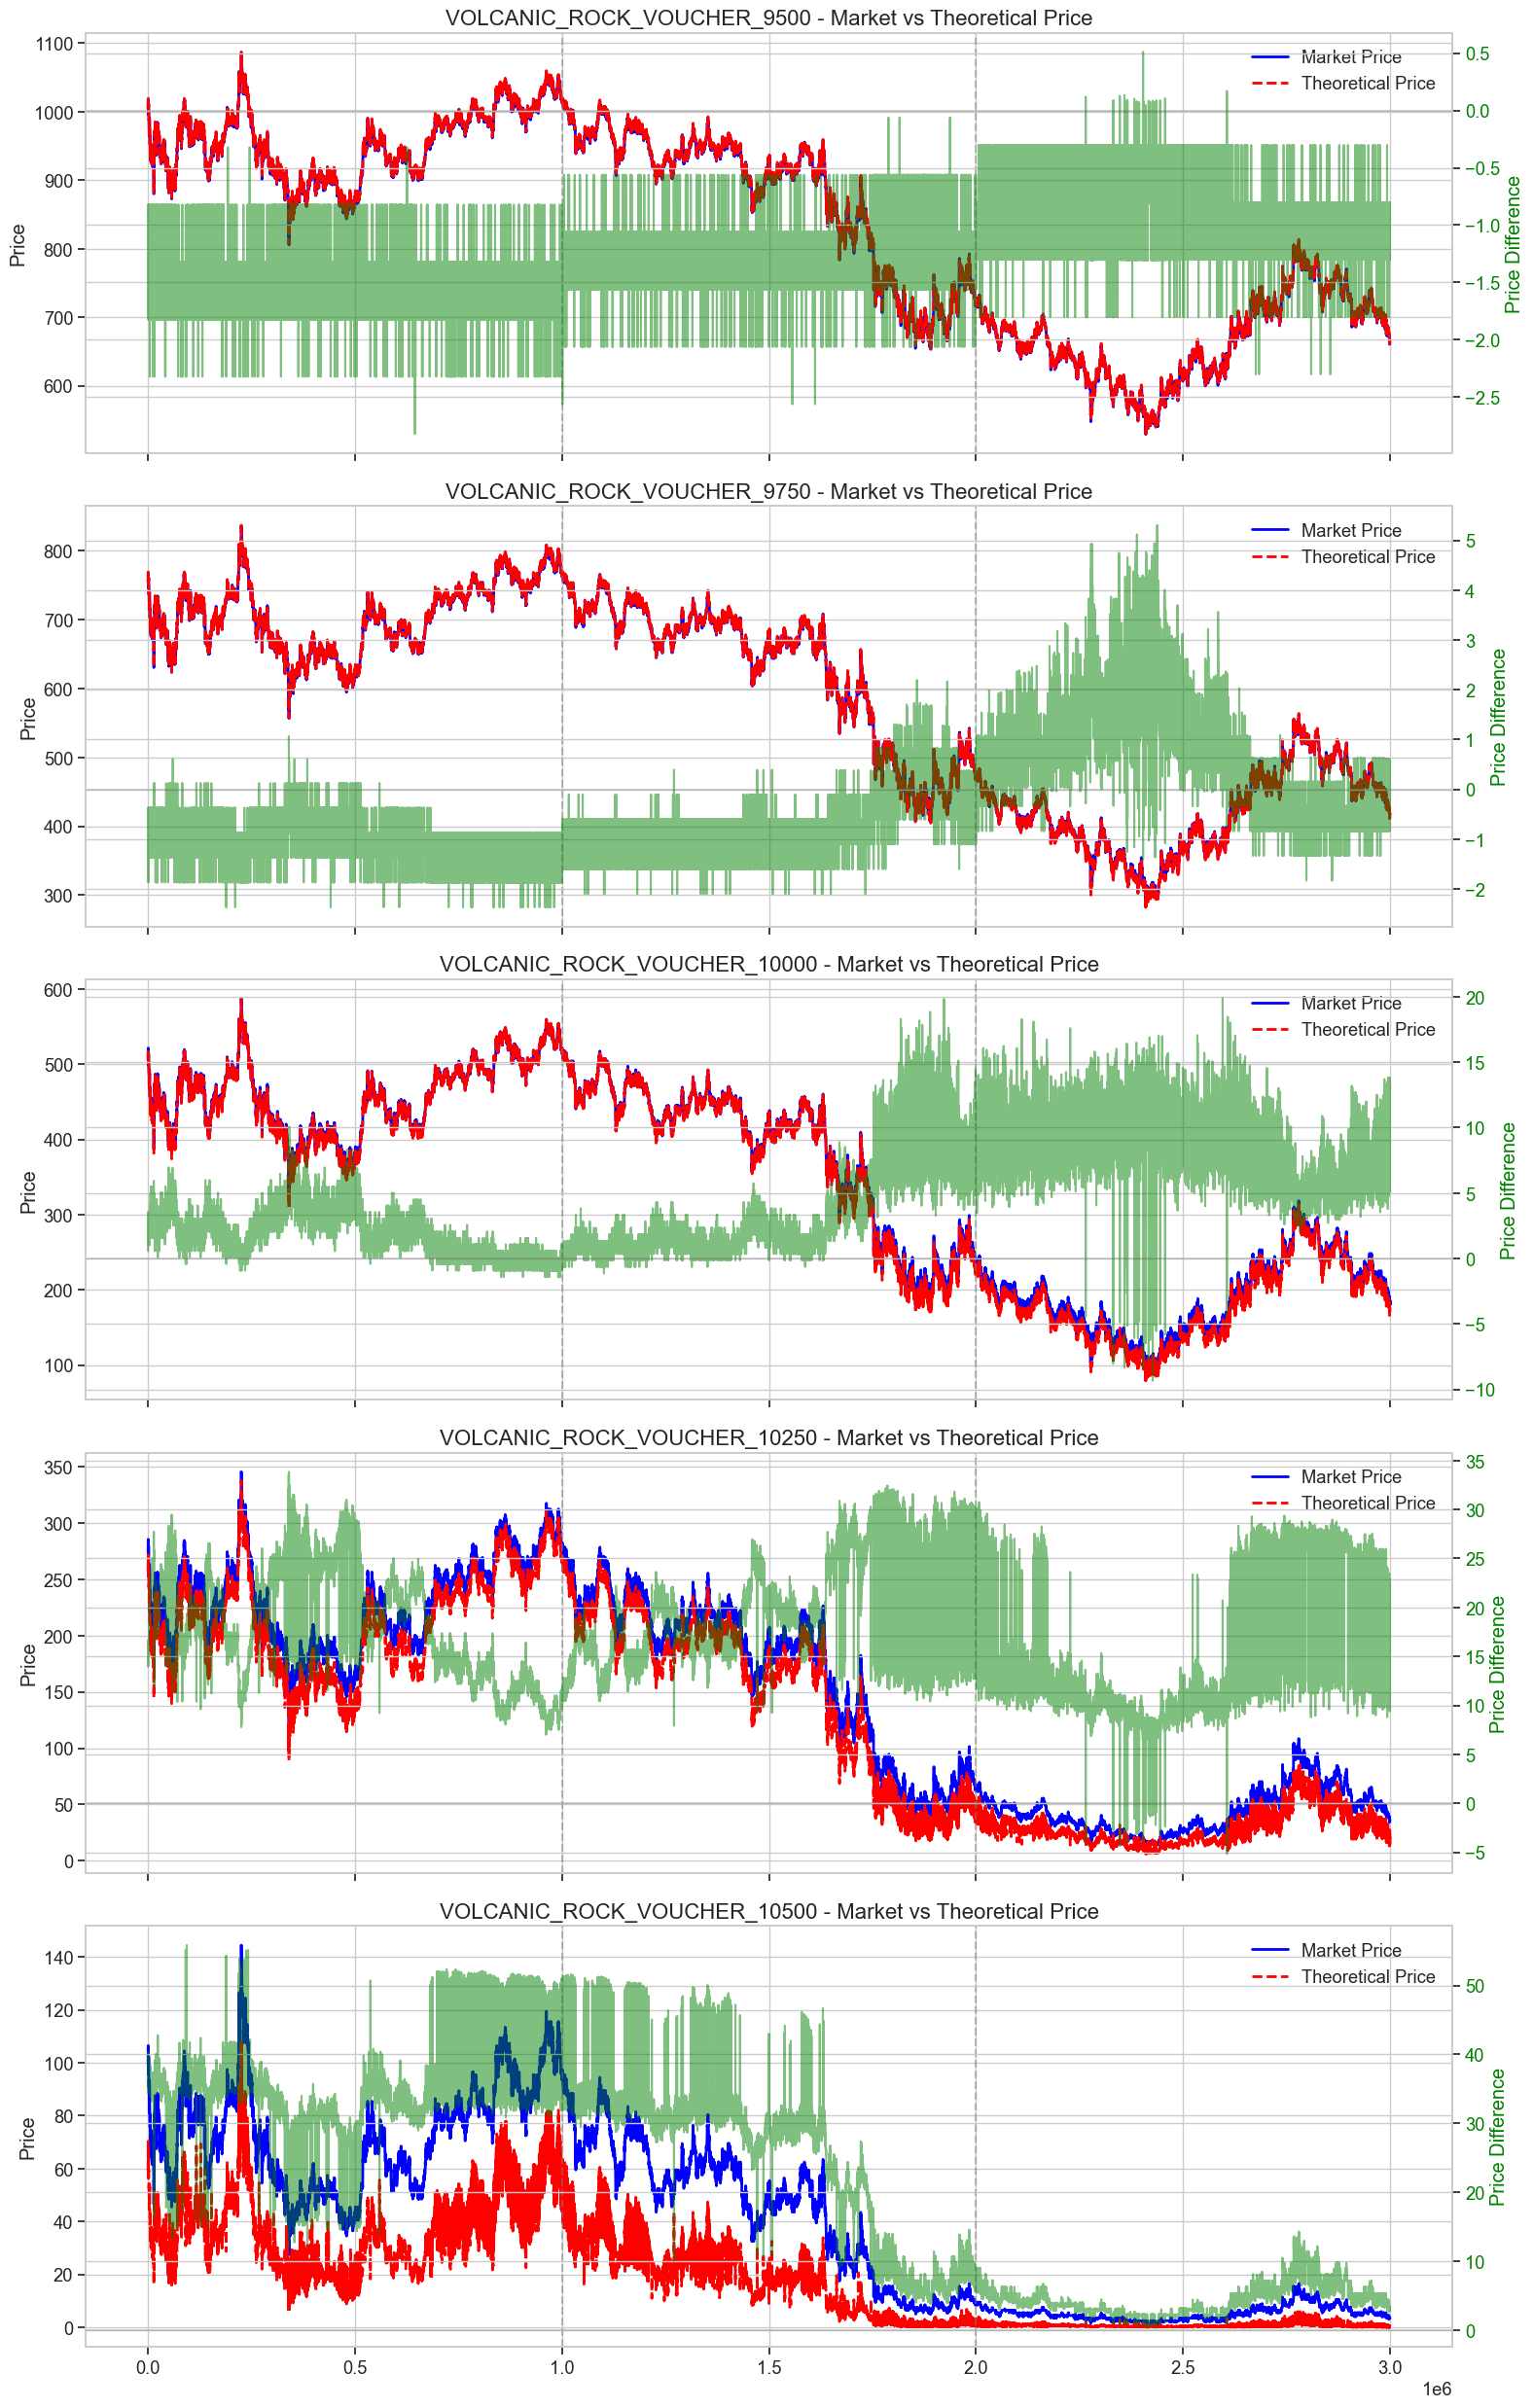

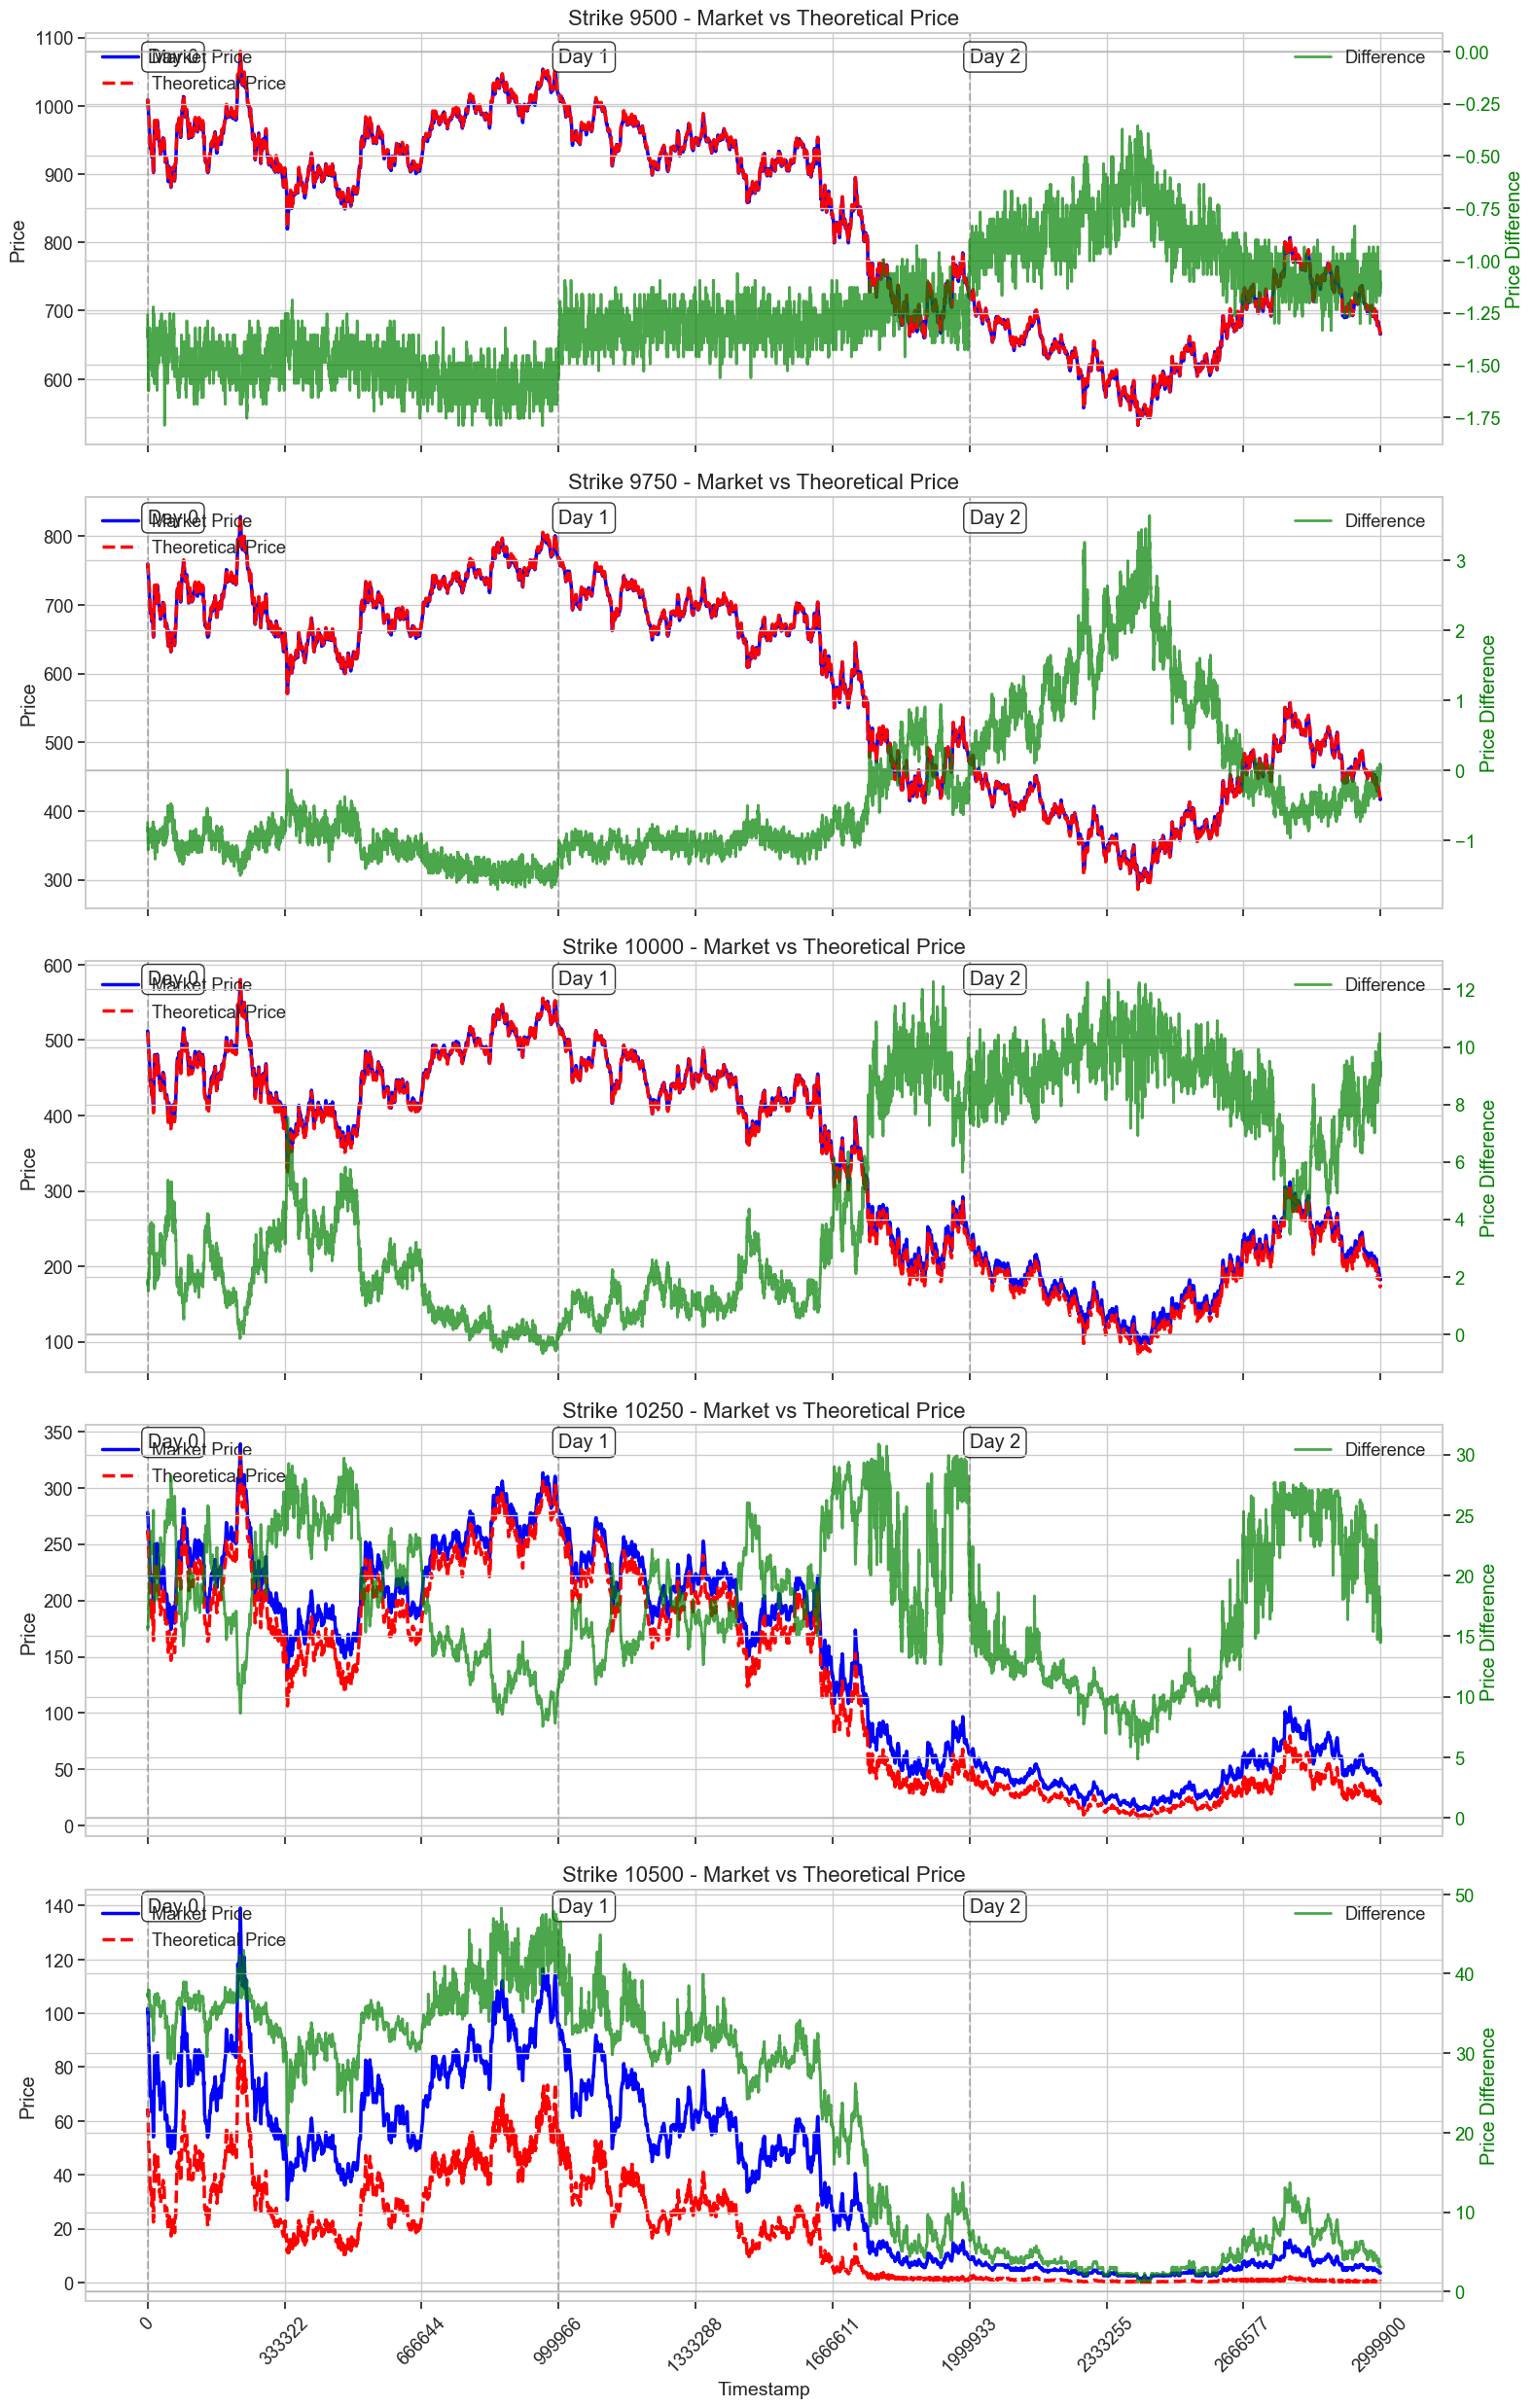

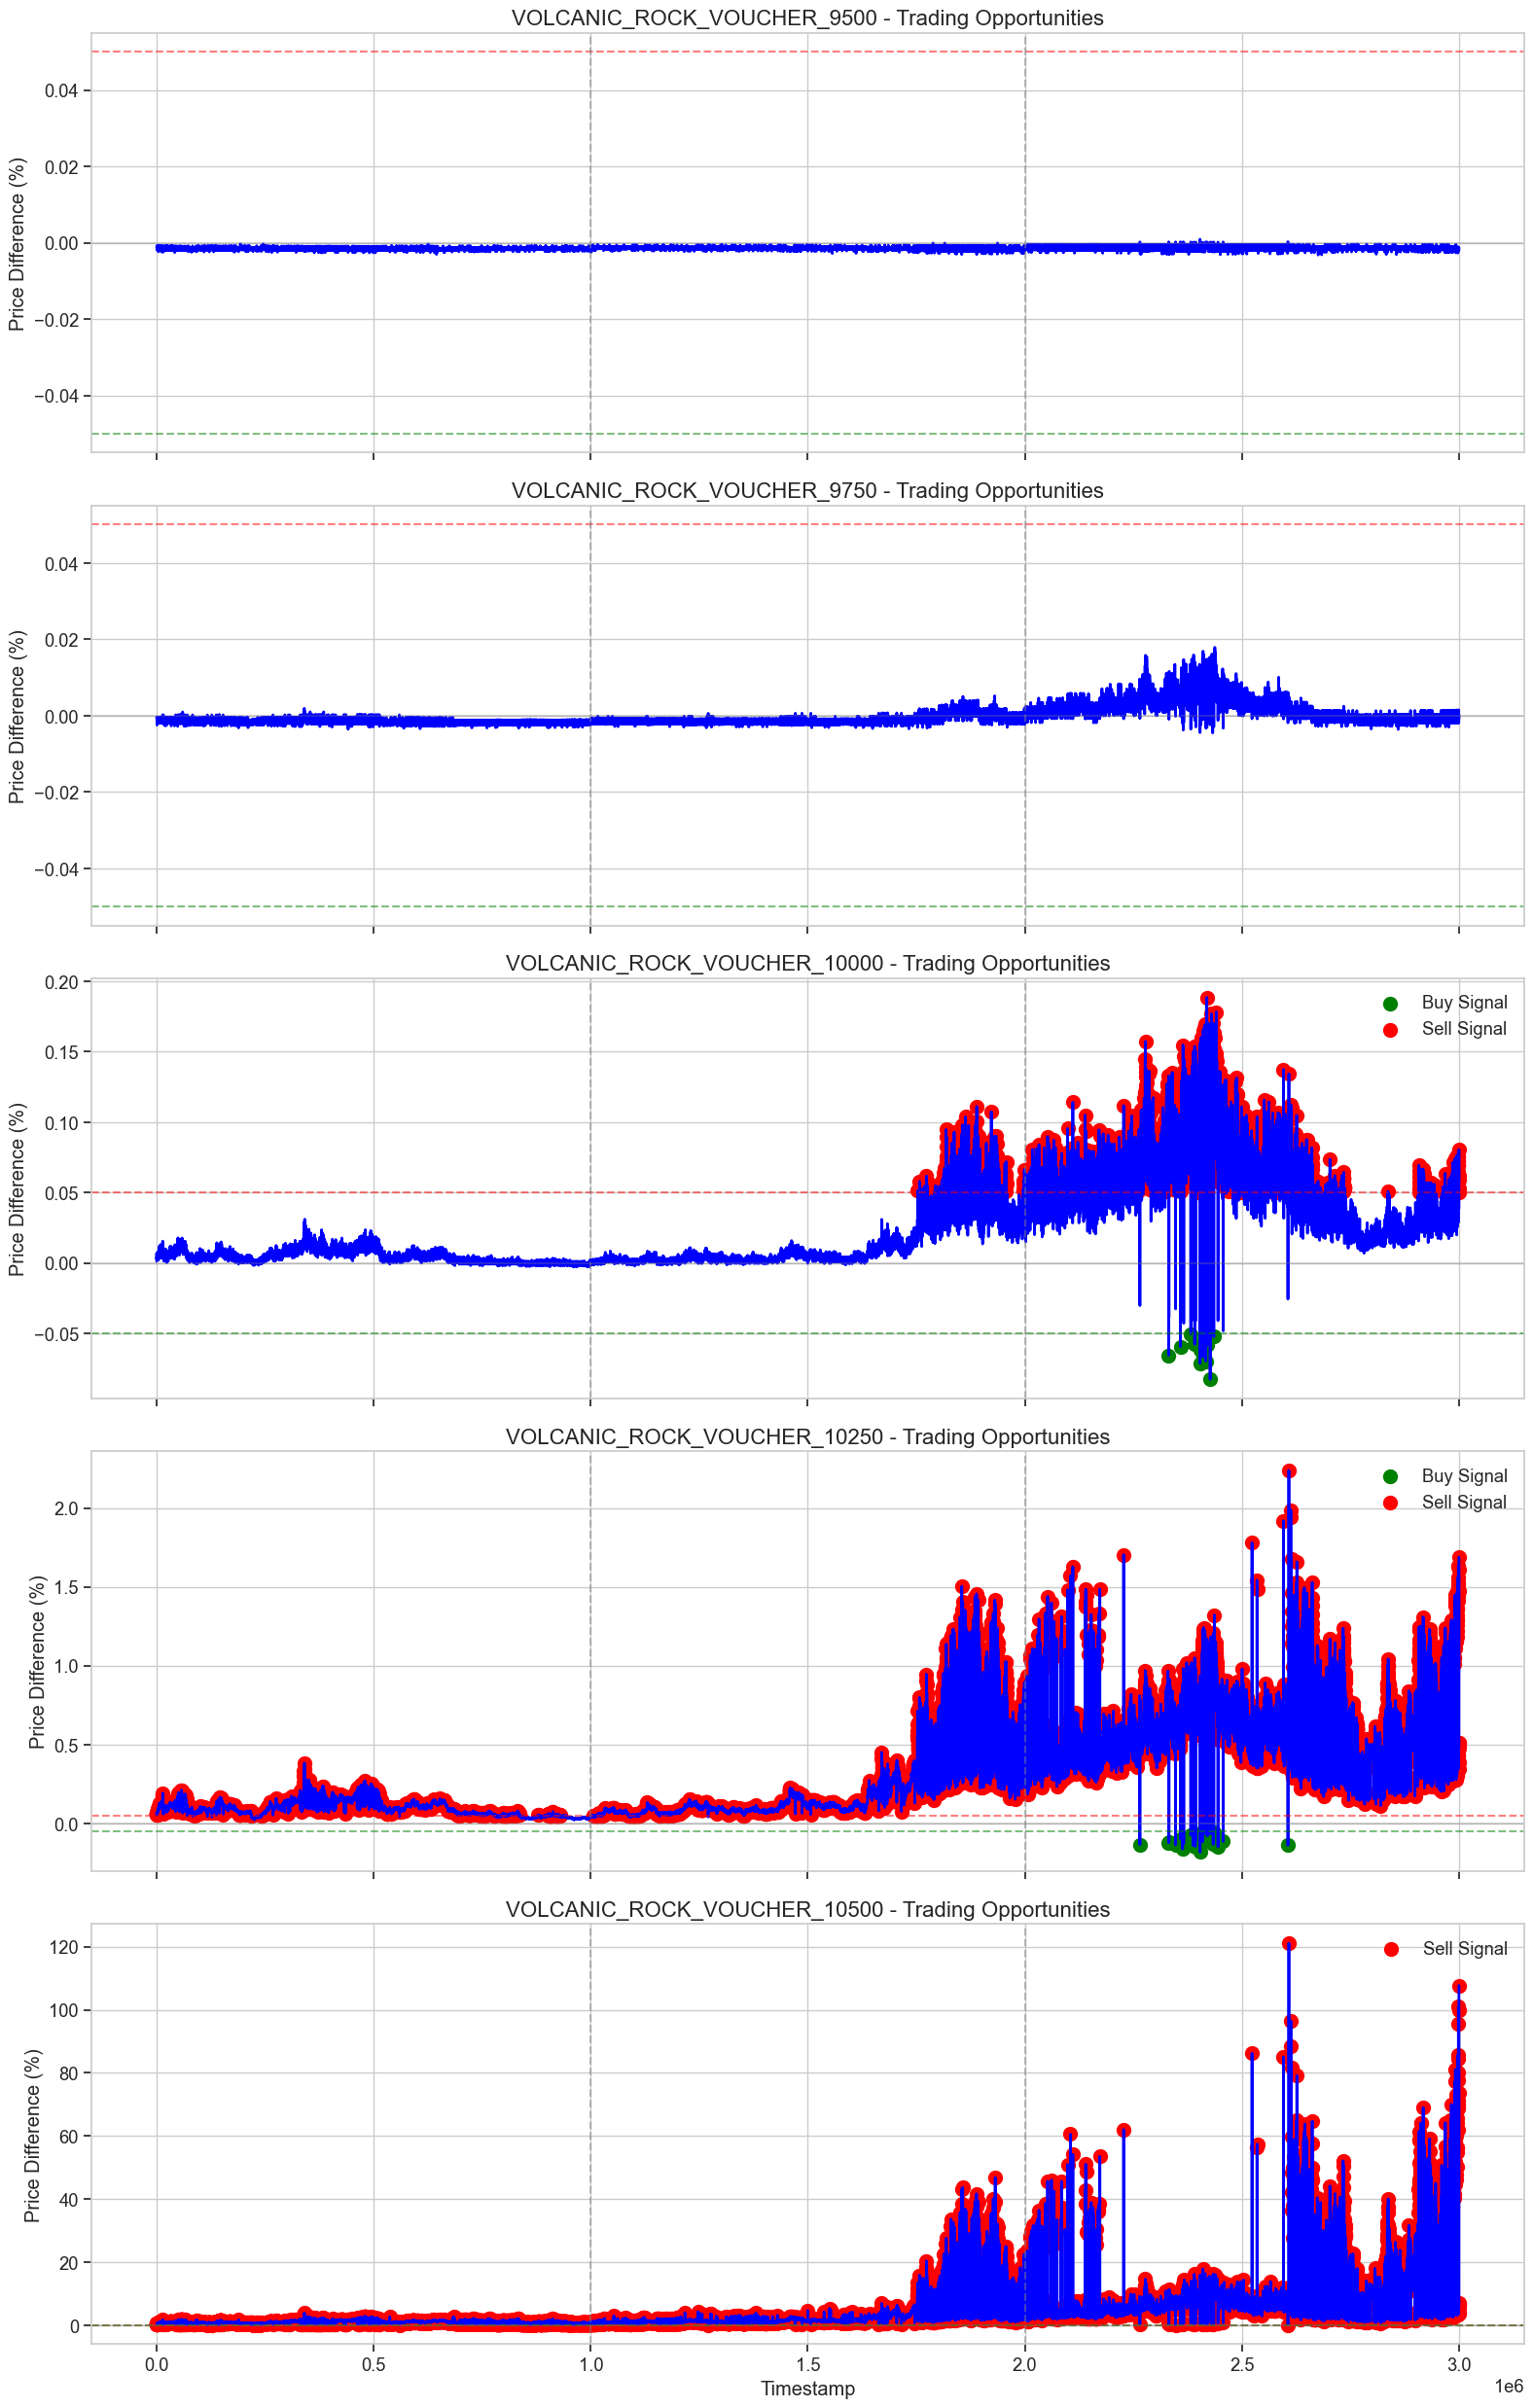

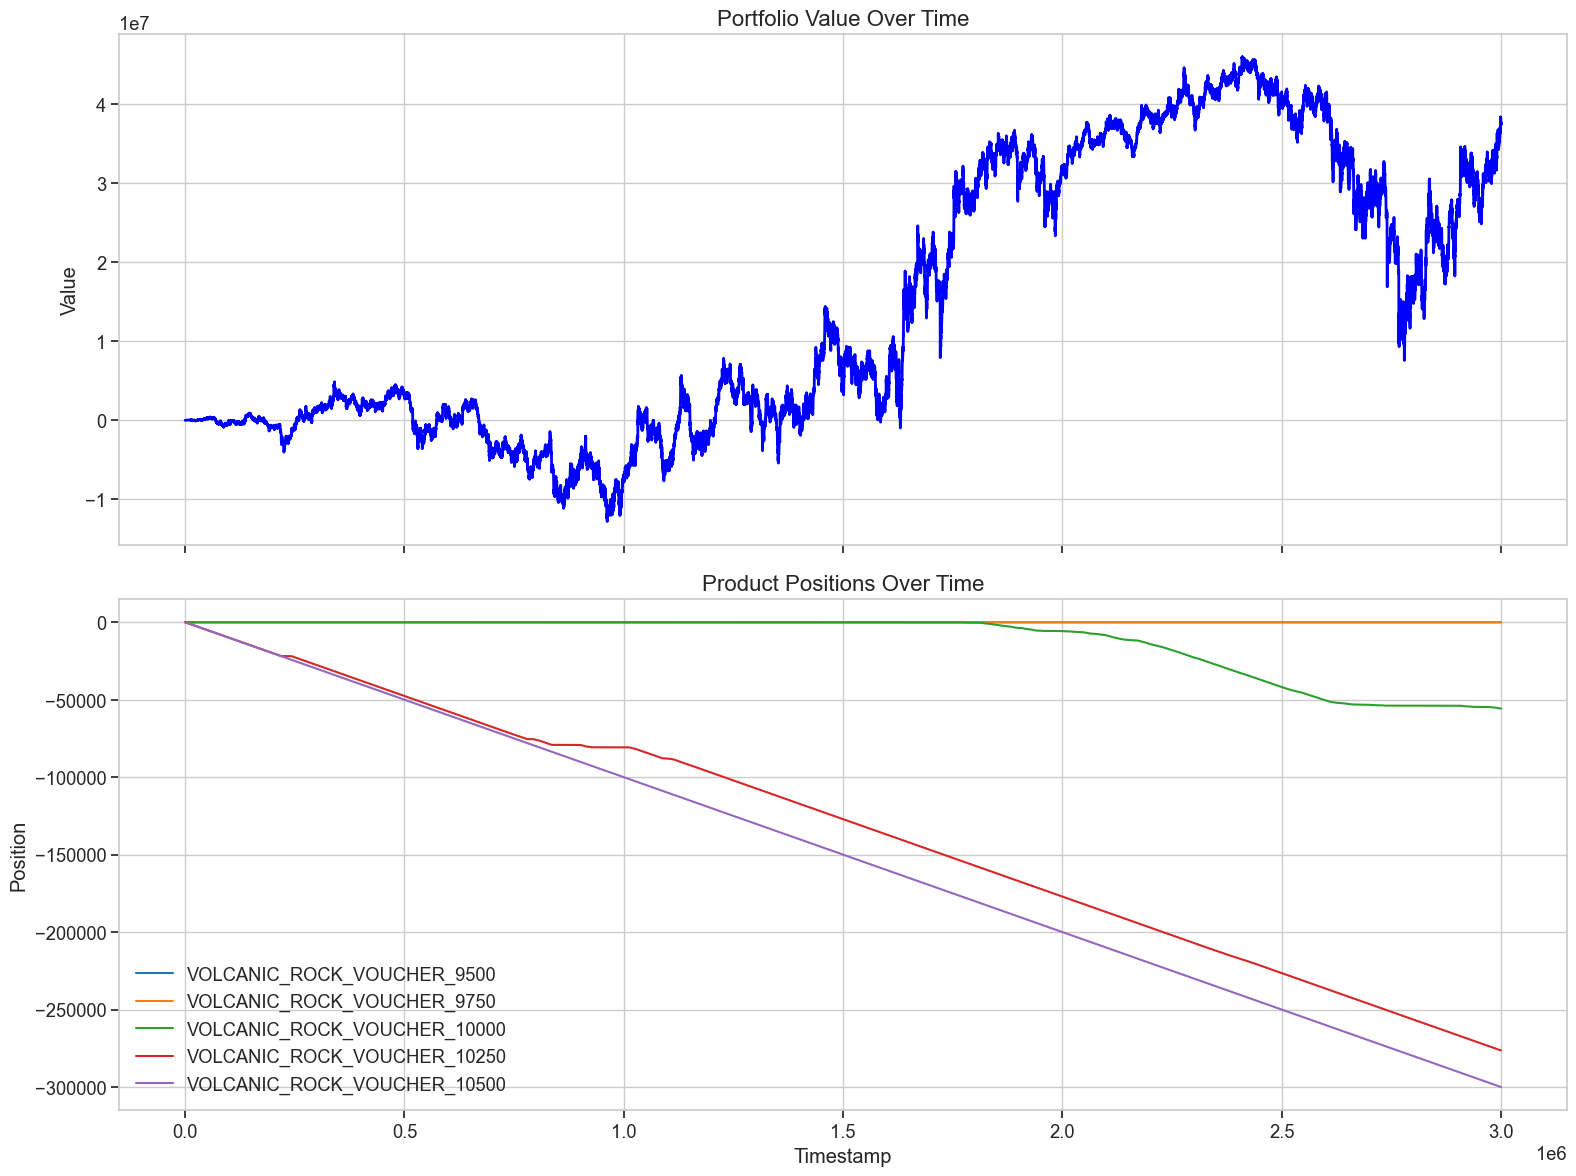

In [12]:
# 3. Plot volatility smile at select timestamps
# Selected timestamps representing different times
selected_timestamps = [0, 10000, 20000, 30000]
smile_fig = plot_volatility_smile(iv_data, voucher_products, selected_timestamps)
smile_fig.savefig('volatility_smile.png')

# 4. Theoretical vs Market prices
price_data = calculate_theoretical_prices(data, voucher_products, strike_prices)
price_comp_fig = plot_theoretical_vs_market(price_data, voucher_products)
# Plot using the improved function for better visualization
price_comp_fig = plot_theoretical_vs_market_improved(price_data, voucher_products)
# price_comp_fig.savefig('theoretical_vs_market.png')

# 5. Trading opportunities
opportunity_data = identify_trading_opportunities(price_data, voucher_products, 0.05)
opportunity_fig = plot_trading_opportunities(opportunity_data, voucher_products, 0.05)
# opportunity_fig.savefig('trading_opportunities.png')

# 6. Strategy simulation
portfolio = simulate_strategy(data, voucher_products, strike_prices, 0.05)
performance_fig = plot_strategy_performance(portfolio, voucher_products)
# performance_fig.savefig('strategy_performance.png')

In [13]:
# Improved trading strategy simulation
def improved_simulate_strategy(data, voucher_products, strike_prices, risk_free_rate=0.01):
    """
    Simulate an improved trading strategy based on relative value and options theory
    """
    # Calculate theoretical prices and identify opportunities
    price_data = calculate_theoretical_prices(data, voucher_products, strike_prices, risk_free_rate)
    
    # Initialize portfolio
    portfolio = {
        'timestamp': price_data['timestamp'].tolist(),
        'cash': [0] * len(price_data),
        'positions': {},
        'position_values': {},
        'trading_pnl': [0] * len(price_data),
        'total_value': [0] * len(price_data),
        'trades': []  # To track all trades
    }
    
    # Track underlying position for delta hedging
    portfolio['positions']['VOLCANIC_ROCK'] = [0] * len(price_data)
    portfolio['position_values']['VOLCANIC_ROCK'] = [0] * len(price_data)
    
    for product in voucher_products:
        portfolio['positions'][product] = [0] * len(price_data)
        portfolio['position_values'][product] = [0] * len(price_data)
    
    # Get product prices for valuation
    product_prices = {}
    for product in voucher_products + ['VOLCANIC_ROCK']:
        product_data = extract_product_data(data, product)
        product_prices[product] = dict(zip(product_data['timestamp'], product_data['mid_price']))
    
    # Position size management parameters
    max_position_per_product = 100000  # Maximum position in any one product
    max_position_total = 300000  # Maximum total position
    
    # Strategy parameters
    threshold_pct = {
        'VOLCANIC_ROCK_VOUCHER_9500': 0.03,
        'VOLCANIC_ROCK_VOUCHER_9750': 0.03,
        'VOLCANIC_ROCK_VOUCHER_10000': 0.05,
        'VOLCANIC_ROCK_VOUCHER_10250': 0.07,
        'VOLCANIC_ROCK_VOUCHER_10500': 0.10
    }
    
    # For calculating deltas
    def call_option_delta(S, K, T, r, sigma):
        if T <= 0.001:  # Very close to expiry
            return 1.0 if S > K else 0.0
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return norm.cdf(d1)
    
    # Simulate trading
    for i, ts in enumerate(price_data['timestamp']):
        if i == 0:
            continue  # Skip first timestamp as we need prior data
        
        # Transfer previous positions and cash
        for product in voucher_products + ['VOLCANIC_ROCK']:
            portfolio['positions'][product][i] = portfolio['positions'][product][i-1]
        portfolio['cash'][i] = portfolio['cash'][i-1]
        
        # Get underlying price
        if ts in product_prices['VOLCANIC_ROCK']:
            underlying_price = product_prices['VOLCANIC_ROCK'][ts]
        else:
            underlying_price = None
        
        # Skip if we can't get underlying price
        if underlying_price is None:
            continue
        
        # Calculate time to expiry
        time_to_expiry = price_data.loc[price_data['timestamp'] == ts, 'time_to_expiry'].values[0]
        
        # Calculate total position value for position sizing
        total_position_value = 0
        for product in voucher_products:
            if product in product_prices and ts in product_prices[product]:
                total_position_value += abs(portfolio['positions'][product][i]) * product_prices[product][ts]
        
        # Implement volatility forecasting - add more weight to recent volatility
        recent_price_data = price_data[price_data['timestamp'] < ts].tail(100)
        if not recent_price_data.empty:
            avg_recent_iv = recent_price_data['avg_iv'].mean()
        else:
            avg_recent_iv = 0.15  # Default if no data
        
        # Track trading signals for delta hedging
        buy_signals = {}
        sell_signals = {}
        
        # Process each voucher for trading opportunities
        for product in voucher_products:
            # Skip if price data is missing
            if np.isnan(price_data.loc[i, f'{product}_market']) or np.isnan(price_data.loc[i, f'{product}_theo']):
                continue
            
            # Get market and theoretical prices
            market_price = price_data.loc[i, f'{product}_market']
            theo_price = price_data.loc[i, f'{product}_theo']
            
            # Calculate percentage difference
            if theo_price > 0:
                pct_diff = (market_price - theo_price) / theo_price
            else:
                continue  # Skip if theoretical price is zero
            
            # Get strike price
            strike = strike_prices[product]
            
            # Calculate delta for this option
            option_delta = call_option_delta(underlying_price, strike, time_to_expiry, risk_free_rate, avg_recent_iv)
            
            # Calculate implied volatility for this product
            implied_vol = price_data.loc[i, 'avg_iv'] if 'avg_iv' in price_data.columns else 0.15
            
            # Dynamically adjust threshold based on moneyness and time to expiry
            adjusted_threshold = threshold_pct[product]
            
            # For far out-of-money options, increase threshold
            moneyness = np.log(strike / underlying_price) / np.sqrt(max(0.01, time_to_expiry))
            if abs(moneyness) > 0.5:
                adjusted_threshold *= 1.5
            
            # For options close to expiry, increase threshold
            if time_to_expiry < 0.05:  # Less than ~18 days
                adjusted_threshold *= 2
            
            # Buy signal - theoretical price higher than market price
            if pct_diff < -adjusted_threshold:
                # Position sizing - scale by delta and difference magnitude
                position_delta = min(max_position_per_product, int(5000 * abs(pct_diff) / adjusted_threshold))
                
                # Check if adding this position would exceed our total position limit
                if total_position_value + position_delta * market_price < max_position_total:
                    # Record trading signal for later delta hedging
                    buy_signals[product] = {
                        'quantity': position_delta,
                        'price': market_price,
                        'delta': option_delta
                    }
            
            # Sell signal - market price higher than theoretical price
            elif pct_diff > adjusted_threshold:
                # Position sizing - scale by delta and difference magnitude
                position_delta = min(max_position_per_product, int(5000 * abs(pct_diff) / adjusted_threshold))
                
                # Check if adding this position would exceed our total position limit
                if total_position_value + position_delta * market_price < max_position_total:
                    # Record trading signal for later delta hedging
                    sell_signals[product] = {
                        'quantity': position_delta,
                        'price': market_price,
                        'delta': option_delta
                    }
        
        # Execute trades after evaluating all products
        for product, trade_info in buy_signals.items():
            if ts in product_prices[product]:
                quantity = trade_info['quantity']
                price = product_prices[product][ts]
                
                # Execute the trade
                portfolio['positions'][product][i] += quantity
                portfolio['cash'][i] -= price * quantity
                
                # Record the trade
                portfolio['trades'].append({
                    'timestamp': ts,
                    'product': product,
                    'action': 'BUY',
                    'quantity': quantity,
                    'price': price,
                    'delta': trade_info['delta']
                })
        
        for product, trade_info in sell_signals.items():
            if ts in product_prices[product]:
                quantity = trade_info['quantity']
                price = product_prices[product][ts]
                
                # Execute the trade
                portfolio['positions'][product][i] -= quantity
                portfolio['cash'][i] += price * quantity
                
                # Record the trade
                portfolio['trades'].append({
                    'timestamp': ts,
                    'product': product,
                    'action': 'SELL',
                    'quantity': quantity,
                    'price': price,
                    'delta': trade_info['delta']
                })
        
        # Delta hedging with the underlying
        net_delta = 0
        for product in voucher_products:
            position = portfolio['positions'][product][i]
            if position != 0 and ts in product_prices[product]:
                # Calculate option delta
                strike = strike_prices[product]
                option_delta = call_option_delta(underlying_price, strike, time_to_expiry, risk_free_rate, avg_recent_iv)
                
                # Add to net delta exposure
                net_delta += position * option_delta
        
        # Current delta hedge position
        current_hedge = portfolio['positions']['VOLCANIC_ROCK'][i]
        
        # Calculate desired hedge position (negative of net delta)
        target_hedge = -int(net_delta)
        
        # Adjust hedge if significant difference
        if abs(target_hedge - current_hedge) > 1000:
            # Calculate adjustment needed
            hedge_adjustment = target_hedge - current_hedge
            
            # Limit adjustment to available cash
            if hedge_adjustment > 0:  # Need to buy more underlying
                max_buy = min(hedge_adjustment, portfolio['cash'][i] // underlying_price)
                if max_buy > 0:
                    portfolio['positions']['VOLCANIC_ROCK'][i] += max_buy
                    portfolio['cash'][i] -= max_buy * underlying_price
            else:  # Need to sell underlying
                portfolio['positions']['VOLCANIC_ROCK'][i] += hedge_adjustment  # Hedge adjustment is negative
                portfolio['cash'][i] -= hedge_adjustment * underlying_price  # Adding cash (negative * negative)
        
        # Calculate position values and total portfolio value
        for product in voucher_products + ['VOLCANIC_ROCK']:
            if product in product_prices and ts in product_prices[product]:
                price = product_prices[product][ts]
                portfolio['position_values'][product][i] = portfolio['positions'][product][i] * price
            else:
                portfolio['position_values'][product][i] = 0
        
        # Calculate trading P&L
        if i > 0:
            day_pnl = portfolio['cash'][i] - portfolio['cash'][i-1]
            for product in voucher_products + ['VOLCANIC_ROCK']:
                day_pnl += portfolio['position_values'][product][i] - portfolio['position_values'][product][i-1]
            portfolio['trading_pnl'][i] = day_pnl
        
        # Calculate total portfolio value
        portfolio['total_value'][i] = portfolio['cash'][i]
        for product in voucher_products + ['VOLCANIC_ROCK']:
            portfolio['total_value'][i] += portfolio['position_values'][product][i]
    
    return portfolio

# Improved portfolio performance visualization
def plot_improved_portfolio_performance(portfolio, voucher_products):
    """
    Create an enhanced visualization of portfolio performance
    """
    fig = plt.figure(figsize=(16, 20))
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 2, 2, 2])
    
    # 1. Portfolio Value Plot
    ax1 = fig.add_subplot(gs[0])
    portfolio_value = pd.Series(portfolio['total_value'], index=portfolio['timestamp'])
    
    # Apply smoothing for better visualization
    portfolio_value_smooth = portfolio_value.rolling(window=20, min_periods=1).mean()
    
    ax1.plot(portfolio['timestamp'], portfolio_value, 'b-', alpha=0.4, linewidth=1)
    ax1.plot(portfolio['timestamp'], portfolio_value_smooth, 'b-', linewidth=2.5)
    
    # Add annotations for significant points
    max_point = portfolio_value.idxmax()
    min_point = portfolio_value[portfolio_value.index > portfolio['timestamp'][len(portfolio['timestamp'])//3]].idxmin()
    
    ax1.annotate(f'Max: {portfolio_value[max_point]:,.0f}', 
                xy=(max_point, portfolio_value[max_point]),
                xytext=(max_point, portfolio_value[max_point]*1.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='green'),
                color='green', fontsize=12)
    
    ax1.annotate(f'Min: {portfolio_value[min_point]:,.0f}', 
                xy=(min_point, portfolio_value[min_point]),
                xytext=(min_point, portfolio_value[min_point]*0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red'),
                color='red', fontsize=12)
    
    # Calculate and display returns
    if len(portfolio_value) > 0:
        initial_value = portfolio_value.iloc[0]
        final_value = portfolio_value.iloc[-1]
        total_return = ((final_value - initial_value) / abs(initial_value)) * 100 if initial_value != 0 else 0
        
        ax1.set_title(f'Portfolio Value Over Time (Total Return: {total_return:.2f}%)', fontsize=16)
    else:
        ax1.set_title('Portfolio Value Over Time', fontsize=16)
    
    ax1.set_ylabel('Value', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add day separators
    timestamps = portfolio['timestamp']
    if len(timestamps) > 0:
        day_changes = []
        for i in range(1, len(timestamps)):
            if (timestamps[i] - timestamps[i-1]) > 50000:  # Assume large gaps are day changes
                day_changes.append(timestamps[i])
        
        for ts in day_changes:
            ax1.axvline(x=ts, color='gray', linestyle='--', alpha=0.5)
            day_num = len(day_changes) - day_changes[::-1].index(ts)
            ax1.text(ts + 100, ax1.get_ylim()[1] * 0.98, f"Day {day_num}", 
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Daily P&L Plot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    daily_pnl = pd.Series(portfolio['trading_pnl'], index=portfolio['timestamp'])
    
    # Create a colormap based on positive/negative values
    colors = ['red' if x < 0 else 'green' for x in daily_pnl]
    
    # Calculate cumulative sum for rolling P&L
    cumulative_pnl = daily_pnl.cumsum()
    
    # Plot daily P&L
    ax2.bar(daily_pnl.index, daily_pnl.values, color=colors, alpha=0.6, width=5000)
    ax2.plot(cumulative_pnl.index, cumulative_pnl.values, 'b-', linewidth=2)
    
    ax2.set_title('Daily Trading P&L and Cumulative P&L', fontsize=16)
    ax2.set_ylabel('P&L', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.6, label='Positive P&L'),
        Patch(facecolor='red', alpha=0.6, label='Negative P&L'),
        Patch(facecolor='blue', label='Cumulative P&L')
    ]
    ax2.legend(handles=legend_elements, loc='upper left')
    
    # 3. Position Plot
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    
    for product in voucher_products:
        ax3.plot(portfolio['timestamp'], portfolio['positions'][product], 
                label=product.replace('VOLCANIC_ROCK_VOUCHER_', 'Strike '))
    
    # Add underlying position
    ax3.plot(portfolio['timestamp'], portfolio['positions']['VOLCANIC_ROCK'], 
             label='VOLCANIC_ROCK', linestyle='--', linewidth=2, color='black')
    
    ax3.set_title('Product Positions Over Time', fontsize=16)
    ax3.set_ylabel('Position', fontsize=14)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Position Values Plot
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    
    for product in voucher_products + ['VOLCANIC_ROCK']:
        ax4.plot(portfolio['timestamp'], portfolio['position_values'][product], 
                label=product.replace('VOLCANIC_ROCK_VOUCHER_', 'Strike '))
    
    ax4.set_title('Position Values Over Time', fontsize=16)
    ax4.set_ylabel('Value', fontsize=14)
    ax4.set_xlabel('Timestamp', fontsize=14)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # Add proper x-axis labeling
    tick_count = 10
    tick_positions = np.linspace(min(portfolio['timestamp']), max(portfolio['timestamp']), tick_count)
    tick_labels = [f"{int(ts)}" for ts in tick_positions]
    
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    
    plt.tight_layout()
    return fig


# Function to analyze strategy performance metrics
def analyze_strategy_performance(portfolio):
    """
    Calculate and return key performance metrics for the trading strategy
    """
    # Convert to pandas series for easier analysis
    portfolio_value = pd.Series(portfolio['total_value'], index=portfolio['timestamp'])
    daily_pnl = pd.Series(portfolio['trading_pnl'], index=portfolio['timestamp'])
    
    # Calculate basic metrics
    initial_value = portfolio_value.iloc[0]
    final_value = portfolio_value.iloc[-1]
    max_value = portfolio_value.max()
    min_value = portfolio_value.min()
    
    # Returns
    absolute_return = final_value - initial_value
    percent_return = (absolute_return / abs(initial_value)) * 100 if initial_value != 0 else 0
    
    # Maximum drawdown
    cumulative_max = portfolio_value.cummax()
    drawdown = (portfolio_value - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min() * 100
    
    # Daily returns
    daily_returns = daily_pnl / portfolio_value.shift(1)
    daily_returns = daily_returns.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Volatility (annualized)
    daily_volatility = daily_returns.std()
    annualized_volatility = daily_volatility * np.sqrt(252) * 100  # Assuming 252 trading days per year
    
    # Sharpe ratio (annualized, assuming risk-free rate of 0)
    avg_daily_return = daily_returns.mean()
    sharpe_ratio = (avg_daily_return / daily_volatility) * np.sqrt(252) if daily_volatility != 0 else 0
    
    # Profit factor
    profitable_trades = daily_pnl[daily_pnl > 0].sum()
    losing_trades = abs(daily_pnl[daily_pnl < 0].sum())
    profit_factor = profitable_trades / losing_trades if losing_trades != 0 else float('inf')
    
    # Win rate
    win_rate = (daily_pnl > 0).mean() * 100
    
    # Create results dictionary
    metrics = {
        'Initial Value': initial_value,
        'Final Value': final_value,
        'Absolute Return': absolute_return,
        'Percent Return (%)': percent_return,
        'Maximum Value': max_value,
        'Minimum Value': min_value,
        'Maximum Drawdown (%)': max_drawdown,
        'Annualized Volatility (%)': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Profit Factor': profit_factor,
        'Win Rate (%)': win_rate
    }
    
    return metrics

Initial Value                0.000000e+00
Final Value                 -4.431440e+05
Absolute Return             -4.431440e+05
Percent Return (%)           0.000000e+00
Maximum Value                2.985685e+05
Minimum Value               -4.326924e+06
Maximum Drawdown (%)        -1.549223e+03
Annualized Volatility (%)    2.447491e+05
Sharpe Ratio                 4.201830e-02
Profit Factor                9.966265e-01
Win Rate (%)                 1.313667e+01
dtype: float64


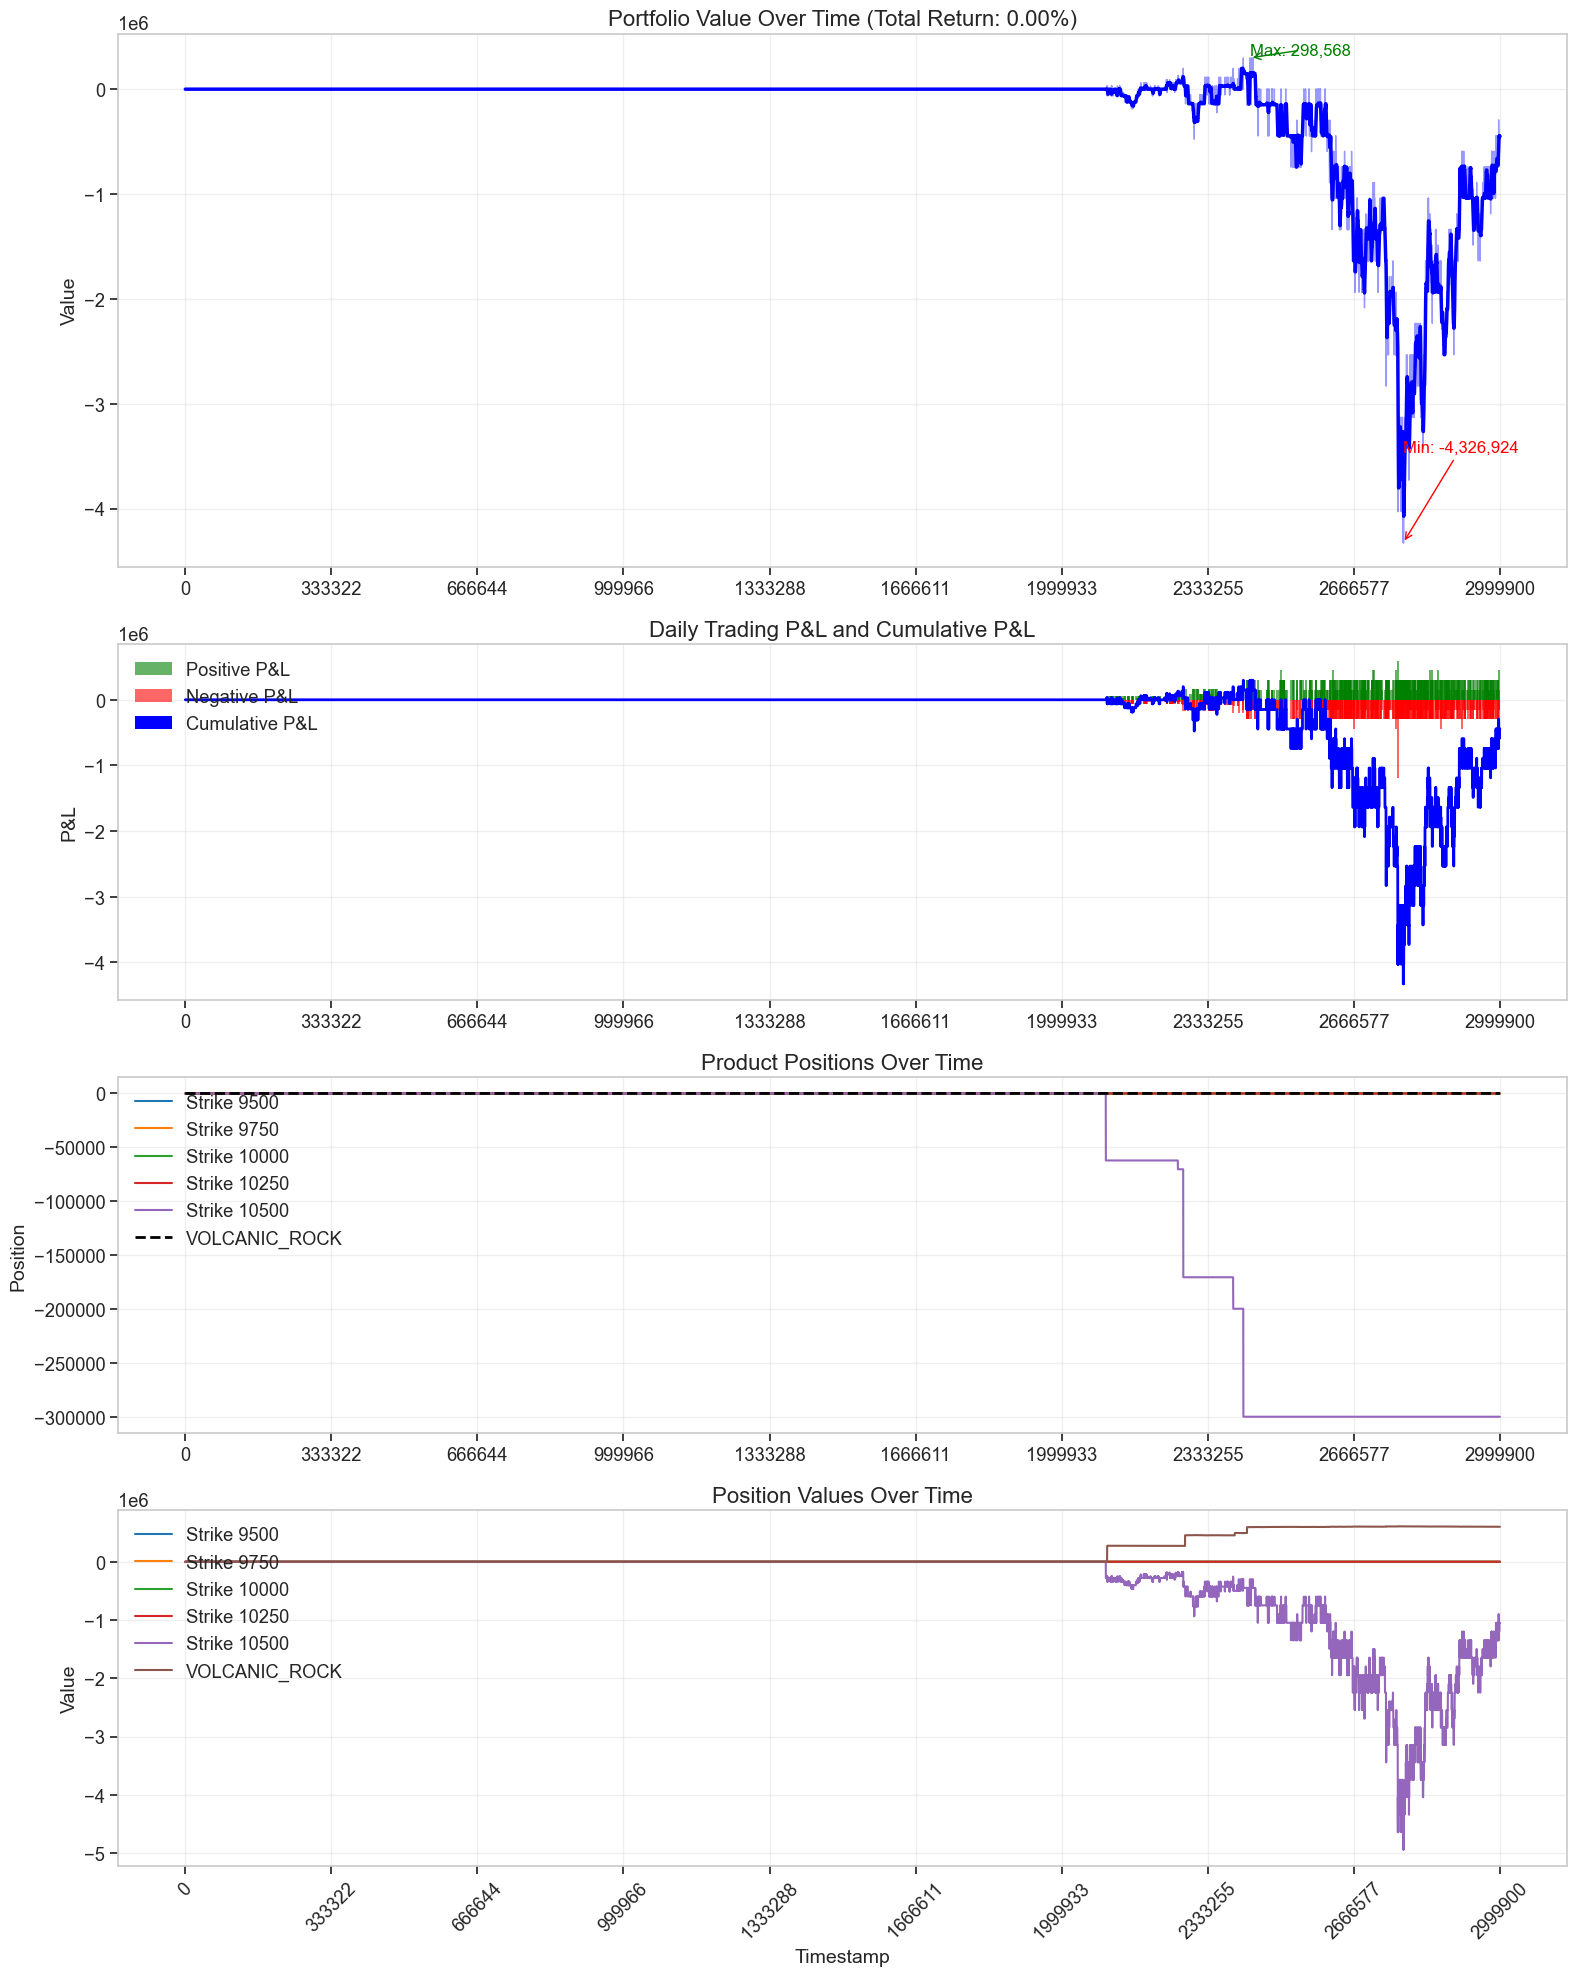

In [14]:
portfolio = improved_simulate_strategy(data, voucher_products, strike_prices)

# Generate enhanced performance visualization
performance_fig = plot_improved_portfolio_performance(portfolio, voucher_products)

# Get detailed performance metrics
metrics = analyze_strategy_performance(portfolio)
print(pd.Series(metrics))

In [15]:
# Volatility Smile Trading Strategy based on the Challenge Hint
def volatility_smile_strategy(data, voucher_products, strike_prices, risk_free_rate=0.01):
    """
    Implement a trading strategy based on the volatility smile hint:
    - Calculate m_t = log(K/St)/sqrt(TTE)
    - Calculate v_t = implied volatility
    - Model the volatility smile curve and find relative mispricing
    - Trade based on deviations from the modeled curve
    """
    # Calculate theoretical prices for baseline
    iv_data = calculate_iv_data(data, voucher_products, strike_prices, risk_free_rate)
    
    # Initialize portfolio
    timestamps = data['timestamp'].unique()
    timestamps.sort()
    
    portfolio = {
        'timestamp': timestamps.tolist(),
        'cash': [0] * len(timestamps),
        'positions': {},
        'position_values': {},
        'total_value': [0] * len(timestamps)
    }
    
    # Initialize positions
    for product in voucher_products + ['VOLCANIC_ROCK']:
        portfolio['positions'][product] = [0] * len(timestamps)
        portfolio['position_values'][product] = [0] * len(timestamps)
    
    # Get product prices for valuation
    product_prices = {}
    for product in voucher_products + ['VOLCANIC_ROCK']:
        product_data = extract_product_data(data, product)
        product_prices[product] = dict(zip(product_data['timestamp'], product_data['mid_price']))
    
    # Create mapping from timestamp to day and time to expiry
    timestamp_to_day = {}
    timestamp_to_tte = {}
    days_data = data.drop_duplicates(['timestamp', 'day'])
    for _, row in days_data.iterrows():
        timestamp_to_day[row['timestamp']] = row['day']
    
    for ts in timestamps:
        if ts in timestamp_to_day:
            day = timestamp_to_day[ts]
            tte = (7 - day) / 365.0  # Convert to years
            timestamp_to_tte[ts] = tte
    
    # Trading parameters
    max_position_per_product = 5000
    min_iv_points_for_model = 3
    
    # Track the volatility smile parameters over time
    smile_params_history = []
    
    # Track trades for later analysis
    trades = []
    
    # Simulation loop
    for i, ts in enumerate(timestamps):
        if i == 0:
            continue  # Skip first timestamp as we need prior data
        
        # Transfer previous positions and cash
        for product in voucher_products + ['VOLCANIC_ROCK']:
            portfolio['positions'][product][i] = portfolio['positions'][product][i-1]
        portfolio['cash'][i] = portfolio['cash'][i-1]
        
        # Get time to expiry
        tte = timestamp_to_tte.get(ts, 0)
        if tte <= 0.01:  # Near expiry, focus on intrinsic value
            continue
        
        # Get underlying price
        if ts in product_prices['VOLCANIC_ROCK']:
            underlying_price = product_prices['VOLCANIC_ROCK'][ts]
        else:
            continue
        
        # Extract IV data points for this timestamp
        ts_iv_data = iv_data[iv_data['timestamp'] == ts]
        if ts_iv_data.empty:
            continue
        
        # Collect moneyness and implied volatility points
        moneyness_points = []
        iv_points = []
        product_info = {}
        
        for product in voucher_products:
            strike = strike_prices[product]
            moneyness_col = f'{product}_moneyness'
            iv_col = f'{product}_iv'
            
            if moneyness_col in ts_iv_data.columns and iv_col in ts_iv_data.columns:
                moneyness = ts_iv_data[moneyness_col].values[0]
                iv = ts_iv_data[iv_col].values[0]
                
                if not np.isnan(moneyness) and not np.isnan(iv) and iv > 0:
                    moneyness_points.append(moneyness)
                    iv_points.append(iv)
                    
                    # Store additional info for trading
                    if ts in product_prices[product]:
                        product_info[product] = {
                            'strike': strike,
                            'moneyness': moneyness,
                            'iv': iv,
                            'price': product_prices[product][ts]
                        }
        
        # Fit the volatility smile curve if we have enough points
        if len(moneyness_points) >= min_iv_points_for_model:
            try:
                # Fit quadratic curve: iv = a*m^2 + b*m + c
                z = np.polyfit(moneyness_points, iv_points, 2)
                a, b, c = z
                
                # Store the smile parameters
                smile_params = {
                    'timestamp': ts,
                    'a': a,
                    'b': b,
                    'c': c,
                    'base_iv': c  # ATM implied volatility
                }
                smile_params_history.append(smile_params)
                
                # Calculate predicted IVs and deviations
                for product, info in product_info.items():
                    m = info['moneyness']
                    predicted_iv = a * m**2 + b * m + c
                    deviation = info['iv'] - predicted_iv
                    info['predicted_iv'] = predicted_iv
                    info['deviation'] = deviation
                    info['relative_deviation'] = deviation / predicted_iv if predicted_iv > 0 else 0
                
                # Look for trading opportunities based on deviations from the smile
                for product, info in product_info.items():
                    relative_deviation = info['relative_deviation']
                    
                    # Trading thresholds - higher for far OTM/ITM options
                    base_threshold = 0.05
                    moneyness_adj = min(3.0, 1.0 + abs(info['moneyness']))
                    threshold = base_threshold * moneyness_adj
                    
                    # Current position
                    current_position = portfolio['positions'][product][i]
                    
                    # Buy underpriced options (negative deviation - lower IV than predicted)
                    if relative_deviation < -threshold:
                        # Scale position size by deviation magnitude
                        size_factor = min(1.0, abs(relative_deviation) / (threshold * 2))
                        qty = int(max_position_per_product * size_factor)
                        
                        # Limit position to avoid extreme exposure
                        max_new_position = 10000 - current_position
                        qty = min(qty, max_new_position)
                        
                        if qty > 0 and info['price'] > 0:
                            # Execute buy trade
                            portfolio['positions'][product][i] += qty
                            portfolio['cash'][i] -= qty * info['price']
                            
                            # Record trade
                            trades.append({
                                'timestamp': ts,
                                'product': product,
                                'action': 'BUY',
                                'quantity': qty,
                                'price': info['price'],
                                'moneyness': info['moneyness'],
                                'iv': info['iv'],
                                'predicted_iv': info['predicted_iv'],
                                'deviation': info['deviation']
                            })
                    
                    # Sell overpriced options (positive deviation - higher IV than predicted)
                    elif relative_deviation > threshold:
                        # Scale position size by deviation magnitude
                        size_factor = min(1.0, abs(relative_deviation) / (threshold * 2))
                        qty = int(max_position_per_product * size_factor)
                        
                        # Limit position to avoid extreme exposure
                        max_new_position = 10000 + current_position
                        qty = min(qty, max_new_position)
                        
                        if qty > 0 and info['price'] > 0:
                            # Execute sell trade
                            portfolio['positions'][product][i] -= qty
                            portfolio['cash'][i] += qty * info['price']
                            
                            # Record trade
                            trades.append({
                                'timestamp': ts,
                                'product': product,
                                'action': 'SELL',
                                'quantity': qty,
                                'price': info['price'],
                                'moneyness': info['moneyness'],
                                'iv': info['iv'],
                                'predicted_iv': info['predicted_iv'],
                                'deviation': info['deviation']
                            })
                
                # Delta hedging using the underlying
                if len(smile_params_history) > 0:
                    # Calculate option deltas and net exposure
                    net_delta = 0
                    for product in voucher_products:
                        position = portfolio['positions'][product][i]
                        
                        if position != 0 and product in product_info:
                            strike = product_info[product]['strike']
                            iv = product_info[product]['iv']
                            
                            # Calculate delta using Black-Scholes
                            d1 = (np.log(underlying_price / strike) + (risk_free_rate + 0.5 * iv**2) * tte) / (iv * np.sqrt(tte))
                            delta = norm.cdf(d1)
                            
                            # Add to net delta exposure
                            net_delta += position * delta
                    
                    # Current delta hedge position
                    current_hedge = portfolio['positions']['VOLCANIC_ROCK'][i]
                    
                    # Calculate desired hedge position (negative of net delta)
                    target_hedge = -int(net_delta)
                    
                    # Adjust hedge if significant difference
                    if abs(target_hedge - current_hedge) > 500:
                        # Calculate adjustment needed
                        hedge_adjustment = target_hedge - current_hedge
                        
                        # Execute hedge trade
                        portfolio['positions']['VOLCANIC_ROCK'][i] += hedge_adjustment
                        portfolio['cash'][i] -= hedge_adjustment * underlying_price
                        
                        # Record hedge trade
                        trades.append({
                            'timestamp': ts,
                            'product': 'VOLCANIC_ROCK',
                            'action': 'HEDGE',
                            'quantity': hedge_adjustment,
                            'price': underlying_price
                        })
            
            except Exception as e:
                print(f"Error fitting volatility smile at timestamp {ts}: {e}")
        
        # Calculate position values and total portfolio value
        for product in voucher_products + ['VOLCANIC_ROCK']:
            if product in product_prices and ts in product_prices[product]:
                price = product_prices[product][ts]
                portfolio['position_values'][product][i] = portfolio['positions'][product][i] * price
            else:
                portfolio['position_values'][product][i] = 0
        
        # Calculate total portfolio value
        portfolio['total_value'][i] = portfolio['cash'][i]
        for product in voucher_products + ['VOLCANIC_ROCK']:
            portfolio['total_value'][i] += portfolio['position_values'][product][i]
    
    # Add trade history to the portfolio object
    portfolio['trades'] = trades
    portfolio['smile_params_history'] = smile_params_history
    
    return portfolio

# Function to plot the volatility smile evolution
def plot_volatility_smile_evolution(portfolio, n_samples=6):
    """
    Plot the evolution of the volatility smile parameters over time
    """
    if 'smile_params_history' not in portfolio or not portfolio['smile_params_history']:
        print("No volatility smile data available")
        return None
    
    # Convert to DataFrame for easier analysis
    smile_params_df = pd.DataFrame(portfolio['smile_params_history'])
    
    # Sample timestamps evenly throughout the trading period
    timestamps = smile_params_df['timestamp'].unique()
    timestamps.sort()
    
    if len(timestamps) > n_samples:
        indices = np.linspace(0, len(timestamps)-1, n_samples, dtype=int)
        sample_timestamps = [timestamps[i] for i in indices]
    else:
        sample_timestamps = timestamps
    
    # Create the plot
    fig, axes = plt.subplots(len(sample_timestamps), 1, figsize=(12, 4*len(sample_timestamps)))
    if len(sample_timestamps) == 1:
        axes = [axes]
    
    # Generate moneyness values for the curve
    moneyness_range = np.linspace(-1.0, 1.0, 100)
    
    for i, ts in enumerate(sample_timestamps):
        # Get smile parameters for this timestamp
        ts_params = smile_params_df[smile_params_df['timestamp'] == ts]
        if ts_params.empty:
            continue
        
        a = ts_params['a'].values[0]
        b = ts_params['b'].values[0]
        c = ts_params['c'].values[0]
        
        # Calculate predicted volatility curve
        predicted_iv = [a * m**2 + b * m + c for m in moneyness_range]
        
        # Plot the curve
        axes[i].plot(moneyness_range, predicted_iv, 'r-', linewidth=2)
        
        # Add formula and parameters
        formula = f"IV = {a:.4f}m² + {b:.4f}m + {c:.4f}"
        axes[i].set_title(f"Volatility Smile at Timestamp {ts} - {formula}", fontsize=14)
        axes[i].set_xlabel("Moneyness (m = ln(K/S)/sqrt(T))", fontsize=12)
        axes[i].set_ylabel("Implied Volatility", fontsize=12)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Function to plot the trading signals based on smile deviations
def plot_volatility_smile_trading_signals(portfolio):
    """
    Visualize how trading signals are generated from volatility smile deviations
    """
    if 'trades' not in portfolio or not portfolio['trades']:
        print("No trade data available")
        return None
    
    # Convert to DataFrame for easier analysis
    trades_df = pd.DataFrame(portfolio['trades'])
    
    # Filter out hedge trades
    option_trades = trades_df[trades_df['product'] != 'VOLCANIC_ROCK'].copy()
    
    # Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot 1: Deviation vs. Moneyness colored by buy/sell
    ax1 = axes[0]
    
    buy_trades = option_trades[option_trades['action'] == 'BUY']
    sell_trades = option_trades[option_trades['action'] == 'SELL']
    
    if not buy_trades.empty:
        ax1.scatter(buy_trades['moneyness'], buy_trades['deviation'], 
                   color='green', label='Buy Signals', alpha=0.7, s=50)
    
    if not sell_trades.empty:
        ax1.scatter(sell_trades['moneyness'], sell_trades['deviation'], 
                   color='red', label='Sell Signals', alpha=0.7, s=50)
    
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax1.set_title("Trading Signals by Volatility Smile Deviation", fontsize=16)
    ax1.set_xlabel("Moneyness (m = ln(K/S)/sqrt(T))", fontsize=14)
    ax1.set_ylabel("IV Deviation from Smile", fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Trading activity over time
    ax2 = axes[1]
    
    # Group trades by timestamp and product
    trade_summary = option_trades.groupby(['timestamp', 'product', 'action']).size().reset_index(name='count')
    
    for product in trade_summary['product'].unique():
        product_data = trade_summary[trade_summary['product'] == product]
        
        buy_data = product_data[product_data['action'] == 'BUY']
        sell_data = product_data[product_data['action'] == 'SELL']
        
        if not buy_data.empty:
            ax2.scatter(buy_data['timestamp'], [product] * len(buy_data), 
                       marker='^', color='green', s=buy_data['count']*30, label=f'{product} Buy' if product == trade_summary['product'].unique()[0] else "")
        
        if not sell_data.empty:
            ax2.scatter(sell_data['timestamp'], [product] * len(sell_data), 
                       marker='v', color='red', s=sell_data['count']*30, label=f'{product} Sell' if product == trade_summary['product'].unique()[0] else "")
    
    ax2.set_title("Trading Activity Over Time", fontsize=16)
    ax2.set_xlabel("Timestamp", fontsize=14)
    ax2.set_ylabel("Product", fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Improved portfolio performance visualization
def plot_volatility_strategy_performance(portfolio):
    """
    Create an enhanced visualization of the volatility smile strategy performance
    """
    fig = plt.figure(figsize=(16, 20))
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 2, 2, 2])
    
    # 1. Portfolio Value Plot
    ax1 = fig.add_subplot(gs[0])
    
    # Apply smoothing for better visualization
    portfolio_value = pd.Series(portfolio['total_value'], index=portfolio['timestamp'])
    portfolio_value_smooth = portfolio_value.rolling(window=20, min_periods=1).mean()
    
    ax1.plot(portfolio['timestamp'], portfolio_value, 'b-', alpha=0.4, linewidth=1)
    ax1.plot(portfolio['timestamp'], portfolio_value_smooth, 'b-', linewidth=2.5)
    
    # Add annotations for significant points
    if len(portfolio_value) > 0:
        max_point = portfolio_value.idxmax()
        max_value = portfolio_value[max_point]
        
        # Find minimum after first third of the timeline
        min_index = len(portfolio_value) // 3
        if min_index < len(portfolio_value):
            min_series = portfolio_value.iloc[min_index:]
            min_point = min_series.idxmin()
            min_value = portfolio_value[min_point]
            
            # Calculate returns
            initial_value = portfolio_value.iloc[0]
            final_value = portfolio_value.iloc[-1]
            total_return = ((final_value - initial_value) / abs(initial_value)) * 100 if initial_value != 0 else 0
            
            # Add annotations only if we have valid min/max
            ax1.annotate(f'Max: {max_value:,.0f}', 
                        xy=(max_point, max_value),
                        xytext=(max_point, max_value*1.1),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='green'),
                        color='green', fontsize=12)
            
            ax1.annotate(f'Min: {min_value:,.0f}', 
                        xy=(min_point, min_value),
                        xytext=(min_point, min_value*0.8),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red'),
                        color='red', fontsize=12)
            
            ax1.set_title(f'Portfolio Value Over Time (Total Return: {total_return:.2f}%)', fontsize=16)
        else:
            ax1.set_title('Portfolio Value Over Time', fontsize=16)
    else:
        ax1.set_title('Portfolio Value Over Time', fontsize=16)
    
    ax1.set_ylabel('Value', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # 2. Position Plot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    for product in portfolio['positions'].keys():
        if product != 'VOLCANIC_ROCK':
            label = product.replace('VOLCANIC_ROCK_VOUCHER_', 'Strike ')
        else:
            label = 'VOLCANIC_ROCK'
        
        ax2.plot(portfolio['timestamp'], portfolio['positions'][product], label=label)
    
    ax2.set_title('Product Positions Over Time', fontsize=16)
    ax2.set_ylabel('Position', fontsize=14)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. Position Values Plot
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    
    for product in portfolio['position_values'].keys():
        if product != 'VOLCANIC_ROCK':
            label = product.replace('VOLCANIC_ROCK_VOUCHER_', 'Strike ')
        else:
            label = 'VOLCANIC_ROCK'
        
        ax3.plot(portfolio['timestamp'], portfolio['position_values'][product], label=label)
    
    ax3.set_title('Position Values Over Time', fontsize=16)
    ax3.set_ylabel('Value', fontsize=14)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Base IV (ATM Volatility) Over Time
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    
    if 'smile_params_history' in portfolio and portfolio['smile_params_history']:
        smile_params_df = pd.DataFrame(portfolio['smile_params_history'])
        ax4.plot(smile_params_df['timestamp'], smile_params_df['base_iv'], 'g-', linewidth=2)
        ax4.set_title('At-The-Money Implied Volatility Over Time', fontsize=16)
        ax4.set_ylabel('ATM IV', fontsize=14)
        ax4.grid(True, alpha=0.3)
    
    # Add proper x-axis labeling
    ax4.set_xlabel('Timestamp', fontsize=14)
    tick_count = 10
    tick_positions = np.linspace(min(portfolio['timestamp']), max(portfolio['timestamp']), tick_count)
    tick_labels = [f"{int(ts)}" for ts in tick_positions]
    
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    
    plt.tight_layout()
    return fig

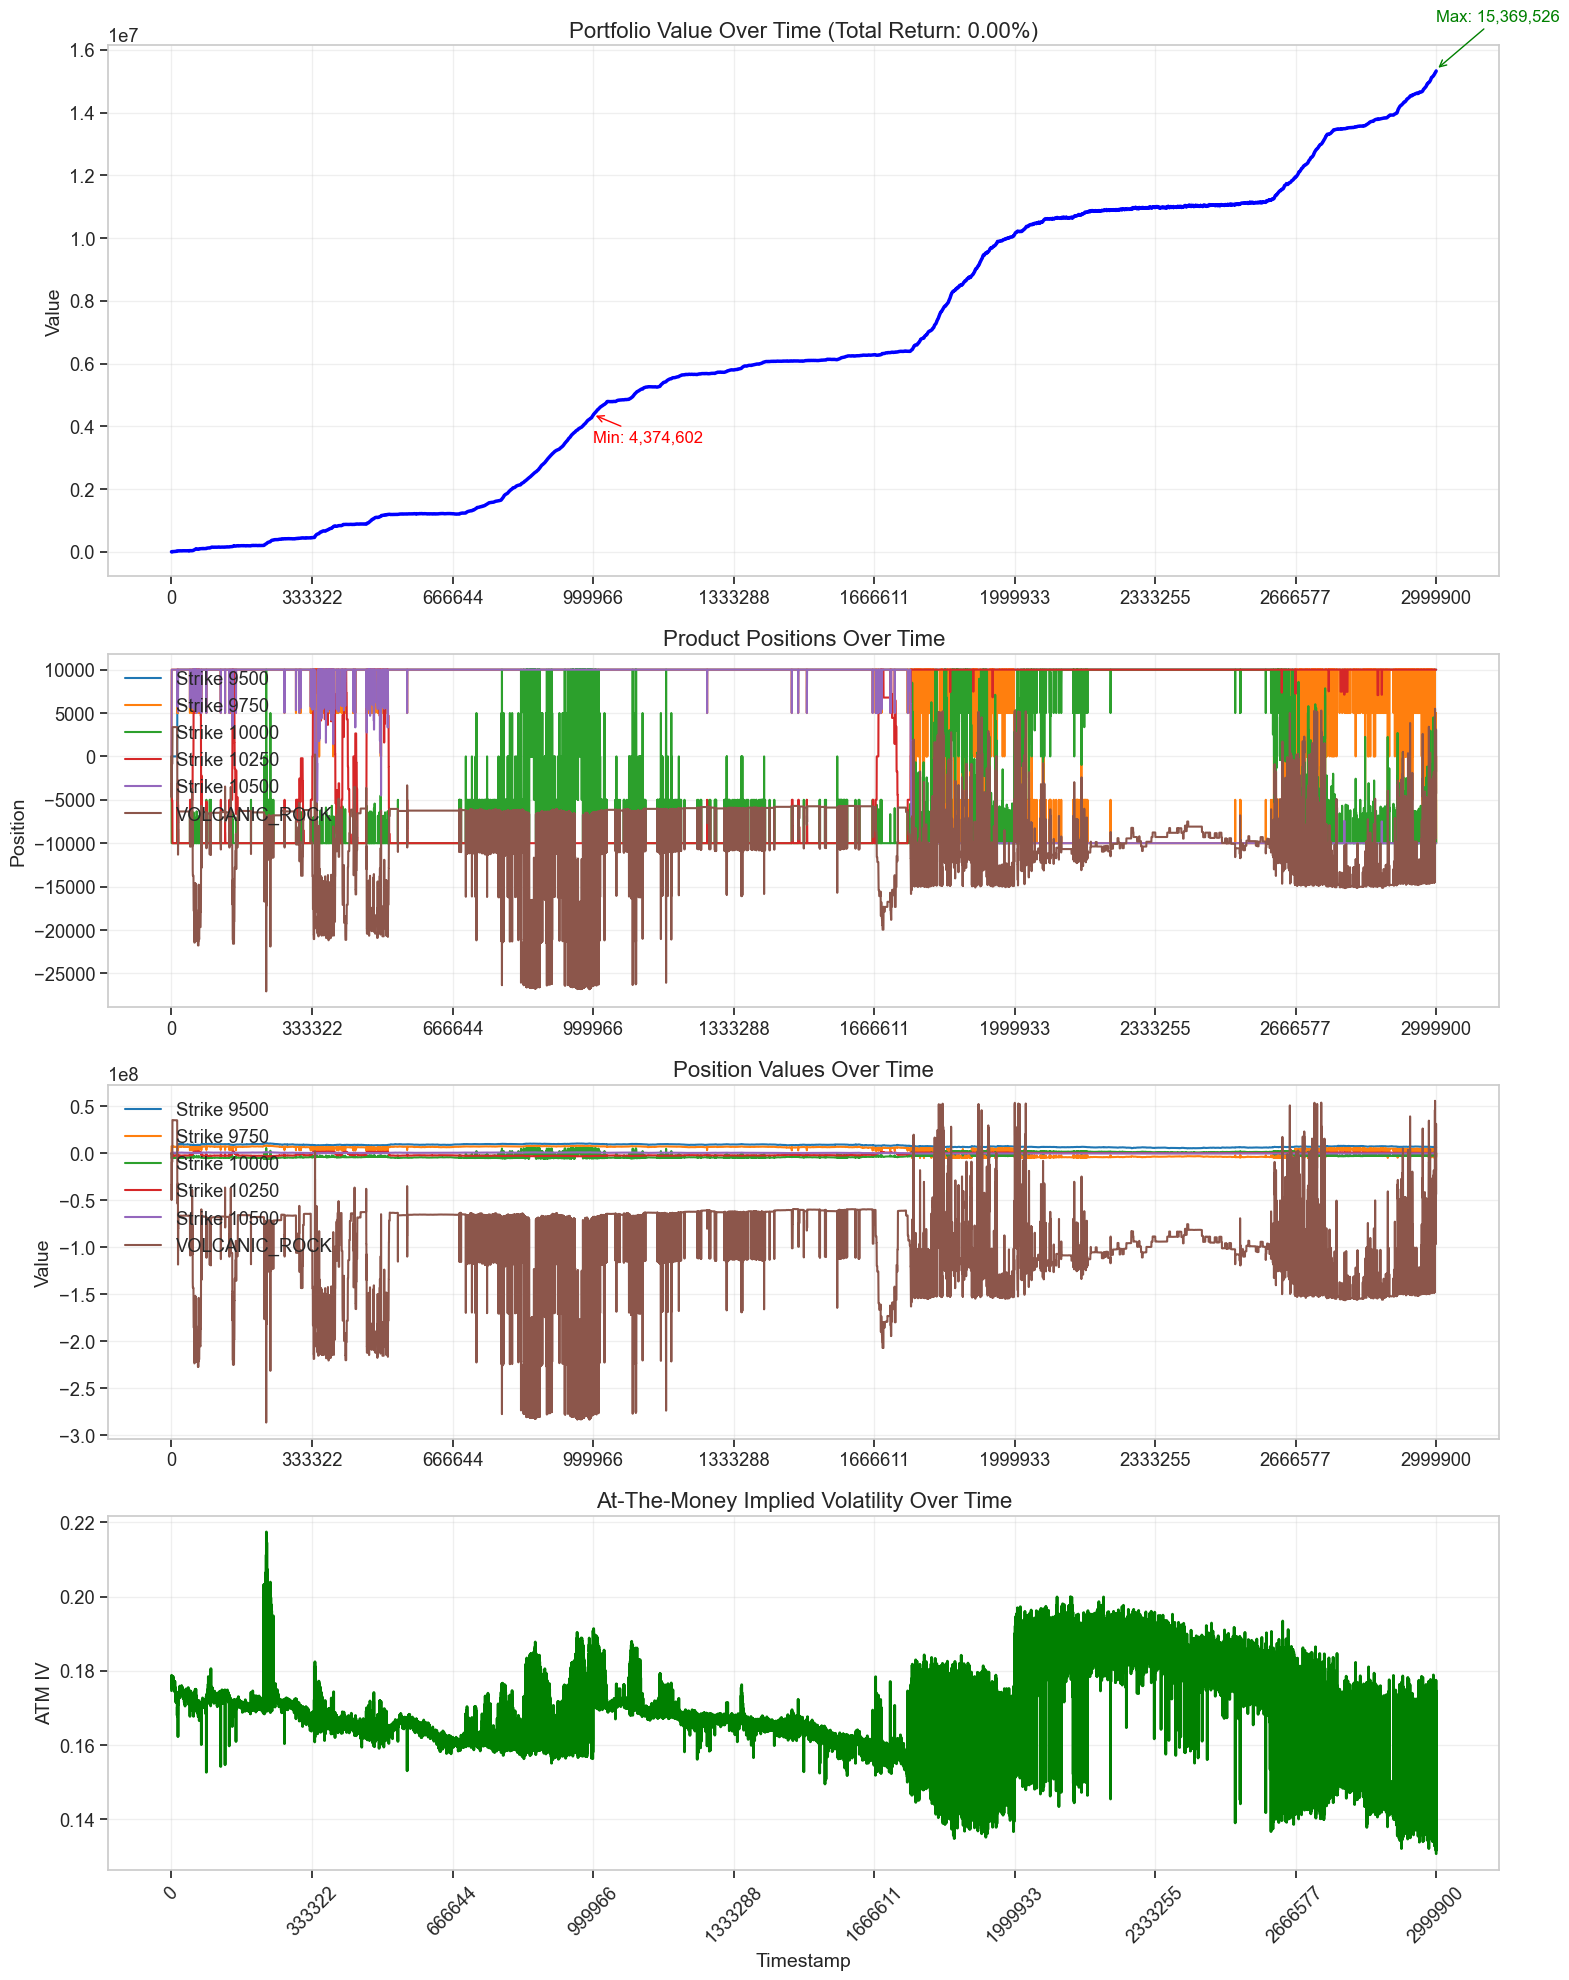

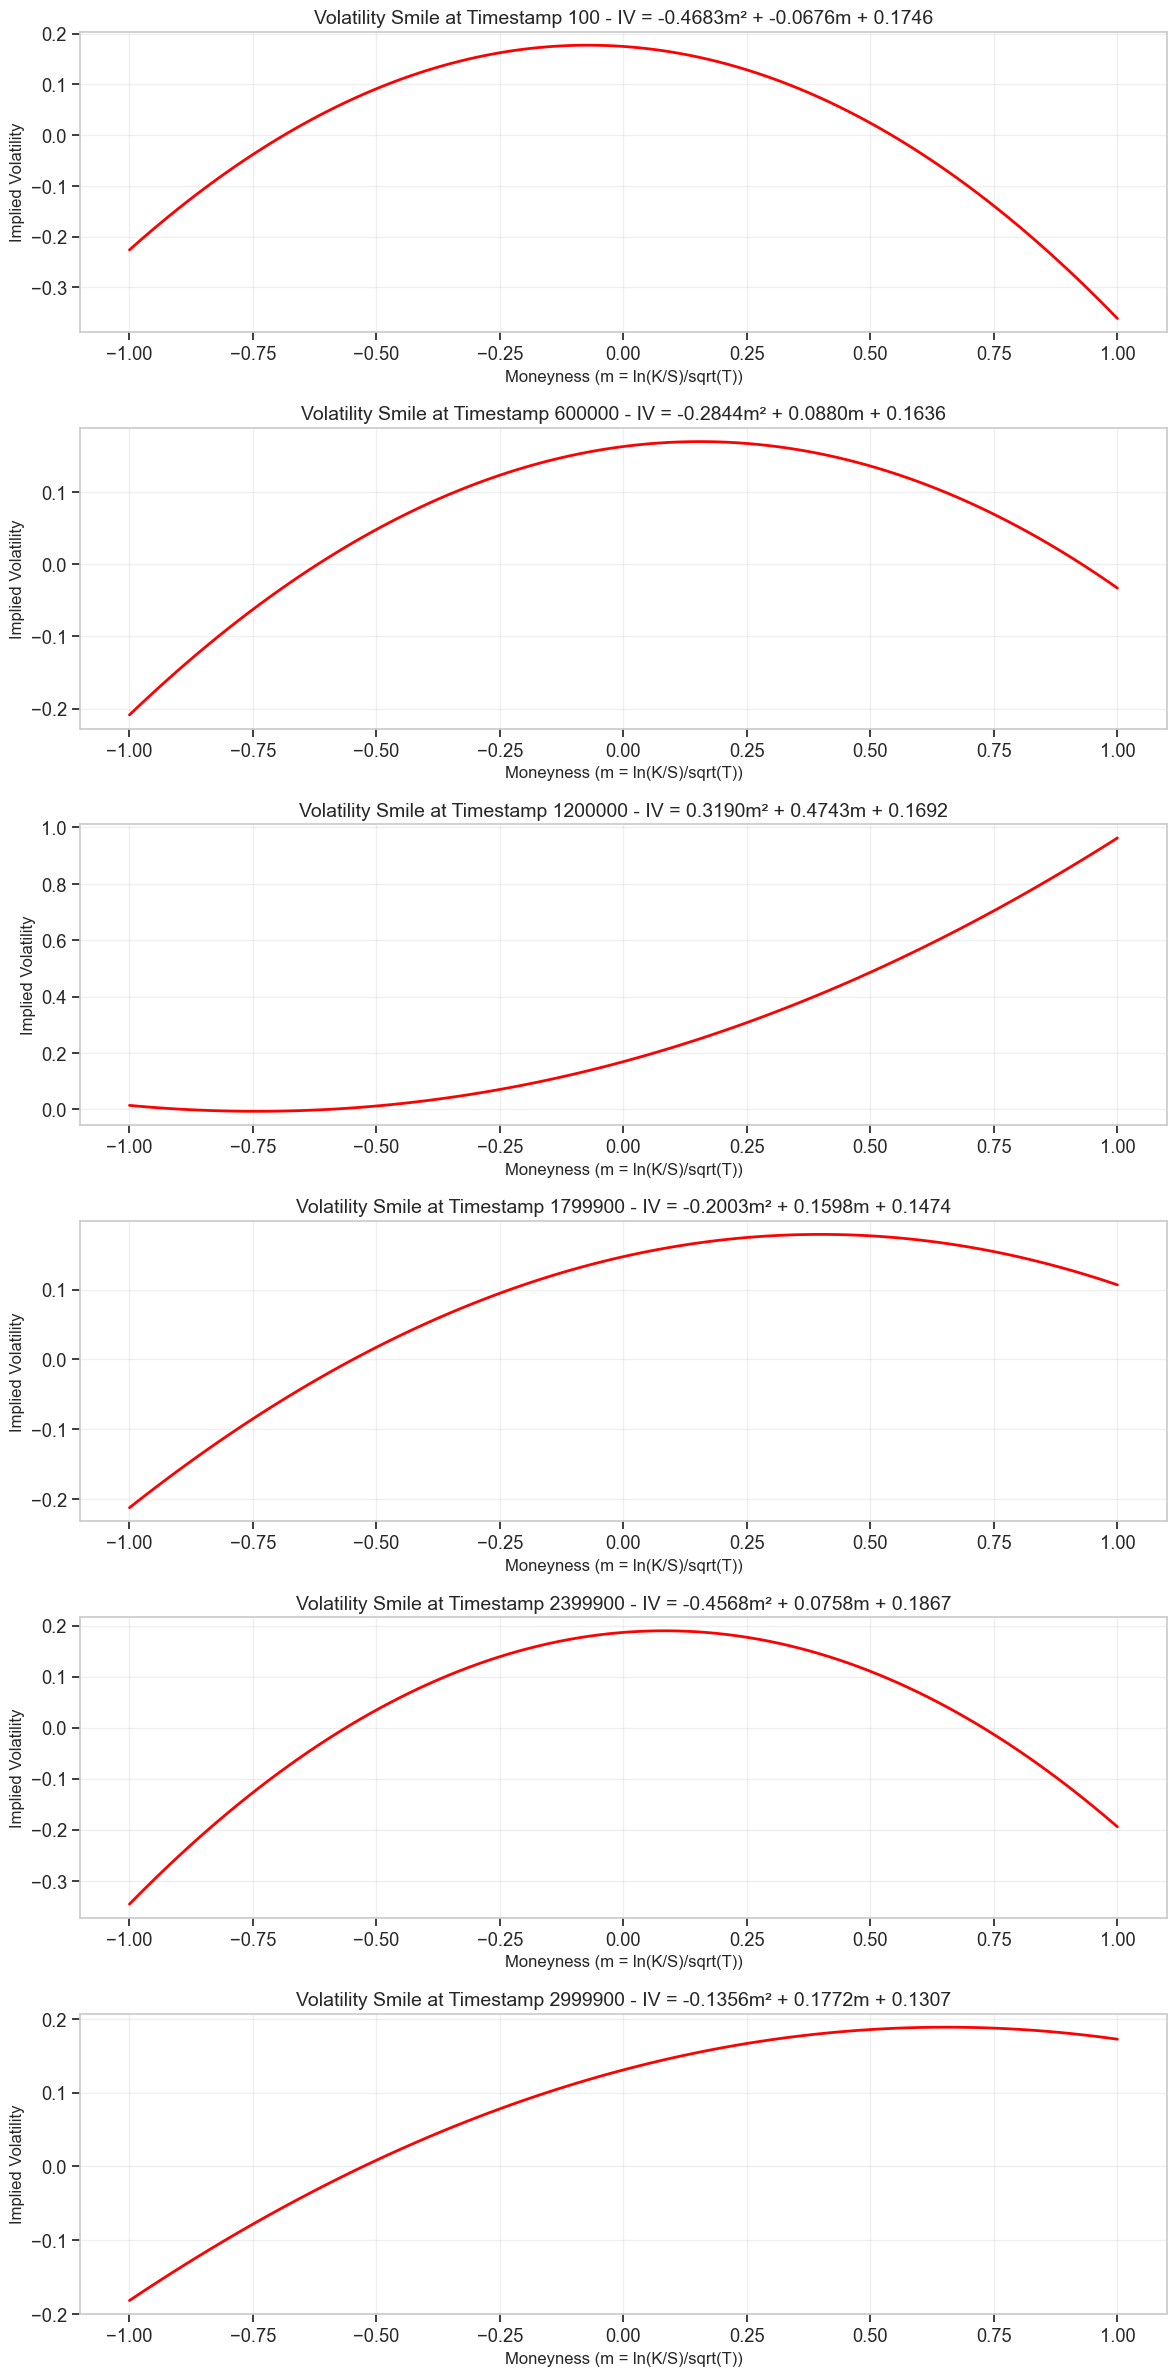

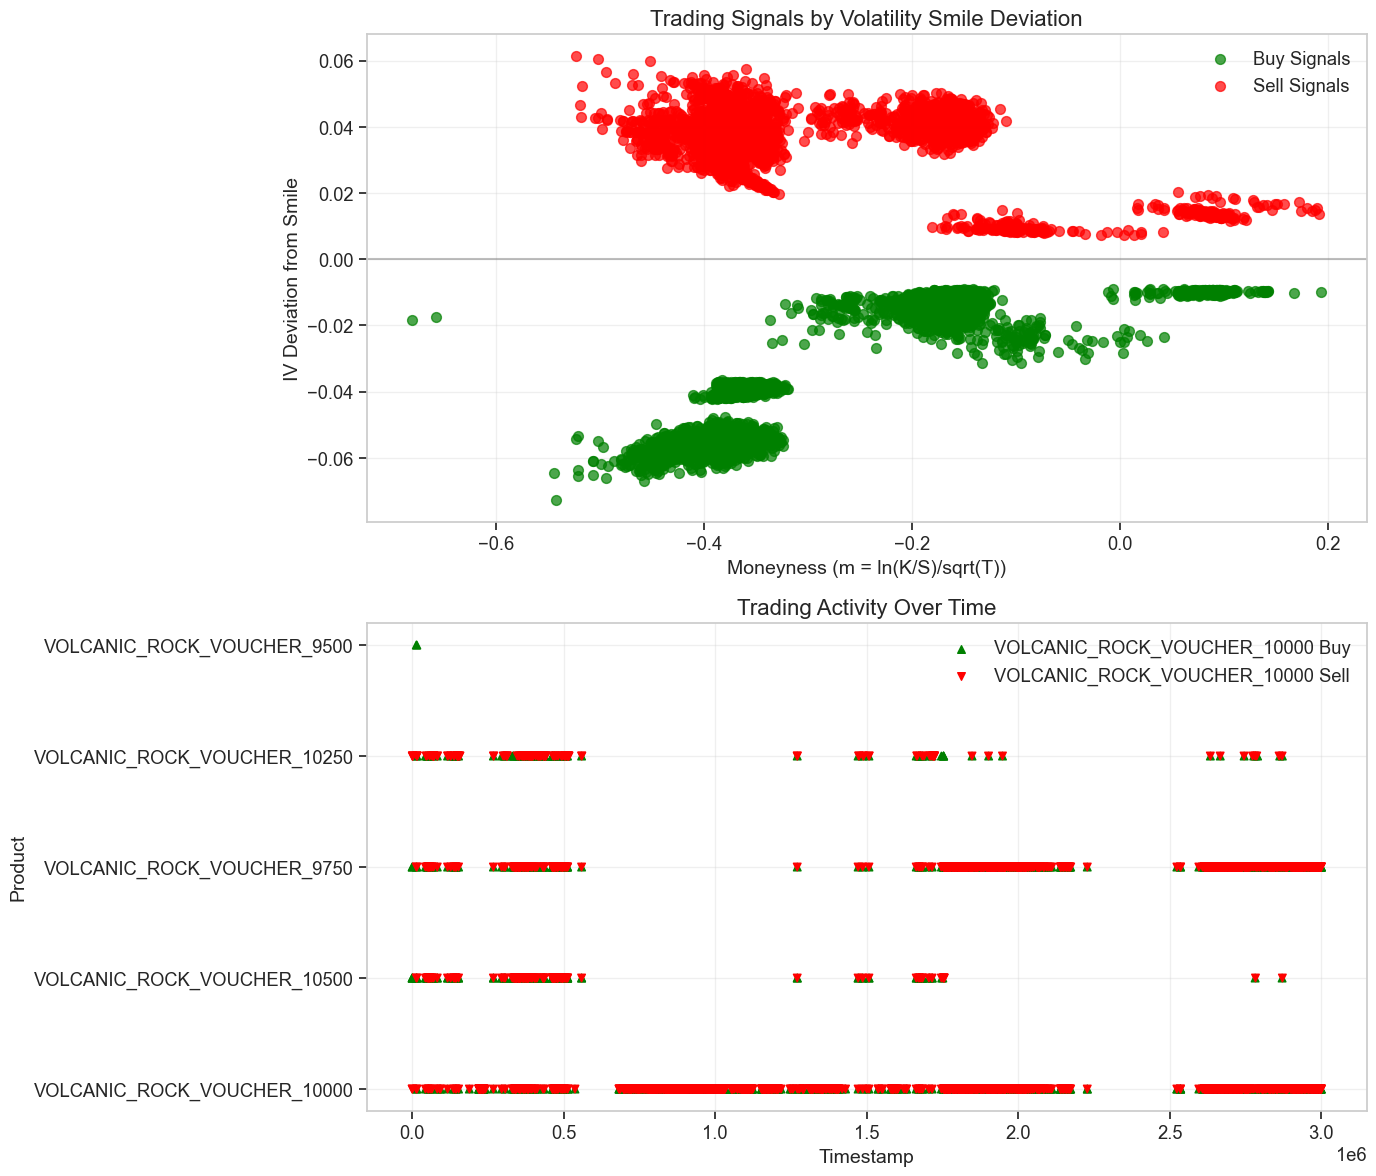

In [16]:
# Run the volatility smile strategy
portfolio = volatility_smile_strategy(data, voucher_products, strike_prices)

# Visualize the strategy performance
performance_fig = plot_volatility_strategy_performance(portfolio)

# Visualize how the volatility smile evolves
smile_fig = plot_volatility_smile_evolution(portfolio)

# Visualize trading signals
signals_fig = plot_volatility_smile_trading_signals(portfolio)